# Packages and Load Metadata

Before proceeding with the project, I will install the required packages for the project and scrape the meta data from the web page using the provided code and load it. I scraped the meta data for several time and combined them together into a final csv.

In [1]:
pip install wordninja

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway
from scipy.sparse import hstack
from wordcloud import WordCloud

from pypdf import PdfReader
import spacy
from spacy import displacy
import wordninja
import re
import csv
import string
import os
from datetime import datetime
from collections import Counter

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, wordnet

from sentence_transformers import SentenceTransformer, util

from dateutil import parser
from dateutil.relativedelta import relativedelta

2024-08-02 13:59:51.482480: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 13:59:51.484490: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-02 13:59:51.527435: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-02 13:59:51.528602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 13:59:52.558302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

We iteratively did the following step to download the data since the data file is very big.

By downloading the data several times, I got a total of 6 years of data, from July 11, 2018 to July 11, 2024.

In [104]:
# For one time of downloading process:

# Load CSV file
metadata = pd.read_csv('metadata.csv')
metadata = metadata.drop(columns = "extras")
metadata.head() # Check the features of metadata

,decision_id,location,title,date,company,decision,tag
0,DRN-2917570,decision/DRN-2917570.pdf,Decision Reference DRN-2917570,11 Jul 2021,Fairmead Insurance Limited,Upheld,Insurance
1,DRN-2919550,decision/DRN-2919550.pdf,Decision Reference DRN-2919550,10 Jul 2021,Royal & Sun Alliance Insurance Plc,Not upheld,Insurance
2,DRN-2824283,decision/DRN-2824283.pdf,Decision Reference DRN-2824283,9 Jul 2021,Aviva Insurance Limited,Not upheld,Insurance
3,DRN-2918976,decision/DRN-2918976.pdf,Decision Reference DRN-2918976,9 Jul 2021,Great Lakes Insurance SE,Upheld,Insurance
4,DRN-2666050,decision/DRN-2666050.pdf,Decision Reference DRN-2666050,9 Jul 2021,Admiral Insurance Company Limited,Upheld,Insurance


Since we are analysing the insurance industry, we do not need the tag column, so we delete it.

In [105]:
# Drop this unnecessary column from metadata
metadata.drop('tag', axis=1, inplace=True)

# Data Cleaning and Preparation by Natural Language Processing

In this section, I will perform several operations to process and analyze text data after getting text from semi-structured text documents. The relevant information should be extracted as text and I also created some features for the later modelling task.

The main parts include the following:

- **Extract Information From PDF files**: First, using the provided code, I downloaded the insurance industry PDF files from July 11, 2018, to July 11, 2024, several times. For each extraction, I performed text extraction from the PDFs and conducted initial cleaning. Then, I merged and saved the extracted text with the metadata into one CSV file for future research.

- **Extract Insurance Product Type**: Using basic NLP techniques with the Spacy package and syntactic parsing, I extracted the types of insurance involved in complaints from the "The complaint" section. At this stage, the text is not fully cleaned because some stopwords such as a/an are needed for type extraction.

- **Data Cleaning**: Further data cleaning includes removing special characters and HTML tags, converting text to lowercase, and preparing it for subsequent keyword extraction.

- **Extract Complaint Reason**: Using NLP and keywords from the "The complaint" section, I identified the causes of insurance disputes.

- **Sentiment Analysis**: I applied the VADER principle to the "What happened" section for sentiment analysis to construct a classification variable.

- **Date Processing and Obtain Dispute Duration**: I extracted the year, the quarter, the month and day of the week of the complaints and used regular expressions to extract the earliest mentioned date in the "What happened" section to determine the duration of disputes.

- **More Data Cleaning**: Removed stopwords to prepare for further processing. Furthermore, we also removed some useless named entities, company names and low-frequency words to reduce noise.

##  Extract Information From PDF files

In this subsection, we extracted the text content from the PDF files. We first handled concatenated words and removed newline characters \n and special characters such as \uf0b7 and removed the signature of FOS. We divided the extracted text into all text and specific sections: 'The complaint', 'What happened', and 'What I’ve decided – and why'. This division will help us perform more targeted text analysis in subsequent steps. These sections were then appended to the last five columns in the metadata. 

We defined some functions separately to extract each subset of the text from PDFs.

In [131]:
# Define a function to handle concatenated words
def correct_spelling(text):
    """
    Use wordninja to find and separate possible cohesive words.
    """
    tokens = text.split()
    corrected_tokens = []
    for token in tokens:
        corrected_tokens.extend(wordninja.split(token))
    corrected_text = ' '.join(corrected_tokens)
    return corrected_text

# Define a function to extract text from PDF
def extract_text(pdf_path):
    """
    Extract text from each page of the PDF and remove unnecessary characters.
    Additionally, remove any leading text that matches a specific pattern like 'DRN-'.
    """
    if os.path.getsize(pdf_path) == 0:
        print(f"The file {pdf_path} is empty. Deleting the file.")
        os.remove(pdf_path)
        raise ValueError(f"The file {pdf_path} was empty and has been deleted.")
    
    text = ""
    reader = PdfReader(pdf_path)
    for page in reader.pages:
        page_text = page.extract_text() or ""  # Append text or empty string if none
        # remove unnecessary characters
        page_text = page_text.replace('\uf0b7', '').replace('\n', ' ') 
        text += page_text
        
    # Remove leading 'DRN-' pattern
    text = re.sub(r'^DRN-\d+', '', text).strip()
    return text

# Define a function to extract each relevant part in a PDF file
def extract_sections(text):
    """
    Extract each relevant section from a PDF file by regular expression method.
    """
    sections = {}
    patterns = {
        "The complaint": [r"The complaint\s*(.*?)(?=\s*What happened)", r"complaint\s*(.*?)(?=\s*What happened)", r"The complaint\s*(.*?)(?=\s*What I’ve decided – and why)", r"complaint\s*(.*?)(?=\s*What I’ve decided – and why)"],
        "What happened": [r"What happened\s*(.*?)(?=\s*What I’ve decided – and why)", r"background\s*(.*?)(?=\s*What I’ve decided – and why)", r"What happened\s*(.*?)(?=\s*my findings)", r"background\s*(.*?)(?=\s*my findings)"],
        "What I’ve decided – and why": [r"What I’ve decided – and why\s*(.*?)(?=\s*My final decision)", r"my findings\s*(.*?)(?=\s*My final decision)", r"What I’ve decided – and why\s*(.*?)(?=\s*my final decision)", r"my findings\s*(.*?)(?=\s*my final decision)", r"What I’ve decided – and why\s*(.*?)(?=\s*My provisional decision)", r"my findings\s*(.*?)(?=\s*My provisional decision)"],
        "My final decision": [r"My final decision\s*(.*)", r"my final decision\s*(.*)", r"My provisional decision\s*(.*)", r"my provisional decision\s*(.*)"]
    }

    # Check if text contains "What happened" or "background"
    if not re.search(r"What happened", text) and not re.search(r"background", text):
        sections["What happened"] = "No detail about it"

    for key, pattern_list in patterns.items():
        found = False
        for pattern in pattern_list:
            match = re.search(pattern, text, re.S)
            if match:
                sections[key] = match.group(1).strip()
                found = True
                break
        if not found:
            sections[key] = 'Not found or not applicable'
    
    return sections

# Define a function to implement the above steps
def extract_text_and_sections(pdf_path):
    """
    Apply functions we created above.
    """
    text = extract_text(pdf_path)
    sections = extract_sections(text)
    # Correct spelling to separate concatenated words
    text = correct_spelling(text)
    return text, sections

def correct_path(path):
    """
    Use correct path to load each pdf file.
    """
    return path.replace('decision/', 'decisions/')

We then added new text columns into metadata.

In [ ]:
# Create a new and empty dataframe to save result later
results = pd.DataFrame()

# Collect all new rows in a list
new_rows = []

# Read each PDF file and start to extract information
for index, row in metadata.iterrows():
    pdf_path = correct_path(row['location'])
    try:
        whole_text, sections = extract_text_and_sections(pdf_path)
        new_row = {
            'decision_id': pdf_path.replace('decisions/', '').replace('.pdf', ''),
            'whole_text': whole_text,
            **sections
        }
        new_rows.append(new_row)
    except ValueError as e:
        print(e)
    except Exception as e:
        print(f"An error occurred while processing {pdf_path}: {e}")
    

# Add rows into a dataframe
results = pd.concat([results, pd.DataFrame(new_rows)], ignore_index=True)

# Save the extracted text as a csv file
results.to_csv('extracted_metadata1821.csv', index=False)

extracted_metadata = pd.read_csv('extracted_metadata1821.csv')

In [ ]:
# Merge two csv together using decision_id
data = pd.merge(metadata, extracted_metadata, on='decision_id', how='inner')
# data.to_csv('data_2023_2024.csv', index=False)
data.to_csv('data_2018_2021.csv', index=False)

### Merge data into a file with 6 years data

Since I downloaded the PDF file three times, then got the text part and merged the formed csv files, I need to merge these three csv files to analyze all the data.

In [137]:
# File paths
file1 = 'data_2018_2021.csv'
file2 = 'data_2021_2023.csv'
file3 = 'data_2023_2024.csv'

# Read CSV files
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

# Concatenate dataframes
data = pd.concat([df1, df2, df3], ignore_index=True)

# Save the merged dataframe to a new CSV file
data.to_csv('merged_data_2018_2024.csv', index=False)

We will use the 6 years data to do the following project.

In [12]:
data = pd.read_csv('merged_data_2018_2024.csv')
# Check the data number
print("We have",len(data),"data in total!")

We have 41351 data in total!


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41351 entries, 0 to 41350
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   decision_id                  41351 non-null  object
 1   location                     41351 non-null  object
 2   title                        41351 non-null  object
 3   date                         41351 non-null  object
 4   company                      41351 non-null  object
 5   decision                     41351 non-null  object
 6   whole_text                   41351 non-null  object
 7   The complaint                41351 non-null  object
 8   What happened                41351 non-null  object
 9   What I’ve decided – and why  41351 non-null  object
dtypes: object(10)
memory usage: 3.2+ MB


In [14]:
# Count the occurrences of 'Not found or not applicable' in each column
not_found_counts = (data == 'Not found or not applicable').sum()

# Display the counts
not_found_counts

decision_id                        0
location                           0
title                              0
date                               0
company                            0
decision                           0
whole_text                         0
The complaint                  11958
What happened                  12004
What I’ve decided – and why    11753
dtype: int64

However, we found that there are so many 'Not found or not applicable' in our data. Some files do not have the what happens section, or it appears with other titles, such as background. This maybe due to the different structure of PDF files over years, so we should filter text data again based on the column 'whole_text'. Besides, some of the PDF files are still all blank, we need to identify and delete them.

In [15]:
# Updated extract_sections function with additional rules after looking up PDFs from past years
def re_extract_sections(text):
    """
    Extract each relevant section from a PDF file by regular expression method with additional rules.
    """
    sections = {}
    patterns = {
        "The complaint": r"(The complaint|The complain|complaint)\s*(.*?)(?=\s*(What happened|what happened|background|Background|What I ve decided and why|What I've decided and why|What I ve decided|my findings|Findings))",
        "What happened": r"(What happened|what happened|background|Background)\s*(.*?)(?=\s*(What I ve decided and why|What I've decided and why|What I ve provisionally decided and why|What I've provisionally decided and why|What I ve decided|What I've decided|my findings|Findings|My final decision|My provisional decision|final decision|my final decision|My final))",
        "What I’ve decided – and why": r"(What I ve decided and why|What I've decided and why|What I've decided|What I ve provisionally decided and why|What I've provisionally decided and why|What I ve decided|my findings|Findings)\s*(.*?)(?=\s*(My final decision|My provisional decision|final decision|my final decision|My final|Putting things right|provisional decision|Ombudsman))"
    }

    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.S | re.I)
        if match:
            sections[key] = match.group(2).strip()
        else:
            sections[key] = 'Not found or not applicable'
    
    return sections

# Function to update the columns with extracted sections and remove rows if PDF is blank
def update_sections(data):
    to_remove = []
    for index, row in data.iterrows():
        text = row['whole_text']
        if text.startswith("K 820 x 14"):
            to_remove.append(index)
        else:
            sections = re_extract_sections(text)
            data.at[index, 'The complaint'] = sections['The complaint']
            data.at[index, 'What happened'] = sections['What happened']
            data.at[index, 'What I’ve decided – and why'] = sections['What I’ve decided – and why']
    
    # Remove rows that meet the condition
    data.drop(to_remove, inplace=True)
    return data

# Apply the function to update the data
data = update_sections(data)

In [16]:
# Count the occurrences of 'Not found or not applicable' in each column
not_found_counts = (data == 'Not found or not applicable').sum()

# Display the counts
not_found_counts

decision_id                      0
location                         0
title                            0
date                             0
company                          0
decision                         0
whole_text                       0
The complaint                    0
What happened                  290
What I’ve decided – and why     10
dtype: int64

Since some PDF data files do not have the specified part, such as what happened or what I've decided and why, they are replaced and need to be filtered out for subsequent analysis. 

Now that we have the data ready, we can start processing and keyword extraction.

In [17]:
# Replace 'Not found or not applicable' with 'No details about it'
data.replace('Not found or not applicable', 'No details about it', inplace=True)

In [18]:
data.to_csv('processed_data_2018_2024.csv', index=False)

Now, we saved this processed data in case of running the extraction codes again. We have 34558 data in total.

In [19]:
data = pd.read_csv('processed_data_2018_2024.csv')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34558 entries, 0 to 34557
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   decision_id                  34558 non-null  object
 1   location                     34558 non-null  object
 2   title                        34558 non-null  object
 3   date                         34558 non-null  object
 4   company                      34558 non-null  object
 5   decision                     34558 non-null  object
 6   whole_text                   34558 non-null  object
 7   The complaint                34557 non-null  object
 8   What happened                34558 non-null  object
 9   What I’ve decided – and why  34555 non-null  object
dtypes: object(10)
memory usage: 2.6+ MB


## Extract Insurance Product Type

While reviewing multiple PDF files, I discovered that insurance types primarily appear in the "The complaint" section. These types typically follow personal pronouns or "a/an" and precede words like policy, plan, insurance, cover, or warranty. To extract the product types involved in the complaints, I utilized **Spacy**'s NLP technology. I first targeted the "The complaint" section to extract insurance types, then applied the same method to the "What happened" section. If no result was found, I analyzed the entire text. This process involved iterative extraction using keyword matching and analysis of part-of-speech and phrase relationships. The extracted results were then simplified and deduplicated using these methods, merging similar types to ensure clarity and accuracy. Finally, I removed types with less than 20 data sample, retaining multi-sample data for further analysis of the characteristics of disputed product types, aiding clients in uncovering valuable insights.

In [3]:
# Load SpaCy nlp model in english is very important
nlp = spacy.load('en_core_web_sm')

I first want to use 2 text examples to show part-of-speech and phrase relationships of the rule I used to find the insurance type.

In [4]:
# Example 1 with personal pronoun
sentence1 = "Mr S complains about ... to renew his pet insurance policy."
# Parse sentences into SpaCy document objects
doc = nlp(sentence1)
# To visualize the dependencies of sentences and display them in the browser
displacy.render(doc, style='dep', jupyter=True, options={'distance': 100, 'font': 'Arial','arrow_stroke': 2, 'arrow_width': 6})

# Save image
svg1 = displacy.render(doc, style='dep', jupyter=False, options={'distance': 100, 'font': 'Arial','arrow_stroke': 2, 'arrow_width': 6})
output_path = "dependency_1.svg"
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(svg1)

In [5]:
# Example 2 with a/an
sentence2 = "Mrs C complains ... mis-sold her a private medical insurance policy."
# Parse sentences into SpaCy document objects
doc = nlp(sentence2)
# To visualize the dependencies of sentences and display them in the browser
displacy.render(doc, style='dep', jupyter= True, options={'distance': 110, 'font': 'Arial','arrow_stroke': 2, 'arrow_width': 6})

# Save image
svg2 = displacy.render(doc, style='dep', jupyter=False, options={'distance': 110, 'font': 'Arial','arrow_stroke': 2, 'arrow_width': 6})
output_path = "dependency_2.svg"
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(svg2)

In [22]:
def extract_insurance_type(text):
    """
    Extracts the type of insurance mentioned in the text.

    Args:
    text (str): The input text.

    Returns:
    list: A list of detected insurance types, or None if no valid type is found.
    """
    
    # Check if text is not a string and convert to string if it's a float (NaN)
    if not isinstance(text, str):
        text = str(text)
    
    doc = nlp(text)
    candidate_types = []

    for token in doc:
        # Examine the noun phrase after the possessive pronoun
        if token.pos_ == 'PRON' and token.dep_ in ['poss']:
            subtree = [child for child in token.head.subtree if child.pos_ in ['NOUN', 'ADJ', 'DET', 'PROPN','PUNCT']]
            insurance_type = ' '.join([child.text for child in subtree if child.dep_ in ['amod', 'compound', 'nmod', 'attr', 'appos','poss', 'punct']])
            if any(kw in insurance_type.split()[-3:] for kw in ['policy', 'plan', 'insurance', 'cover','warranty']):
                candidate_types.append(insurance_type)
        
        # Check the noun phrase after "a" or "an"
        if token.text.lower() in ['a', 'an']:
            subtree = [child for child in token.head.subtree if child.pos_ in ['NOUN', 'ADJ', 'DET', 'PROPN','PUNCT']]
            insurance_type = ' '.join([child.text for child in subtree if child.dep_ in ['amod', 'compound', 'nmod', 'attr', 'appos','poss', 'punct']])
            if any(kw in insurance_type.split()[-3:] for kw in ['policy', 'plan', 'insurance', 'cover','warranty']):
                candidate_types.append(insurance_type)

    # Filter out duplicates and ensure they end with specific keywords
    filtered_insurance_types = list(set([itype for itype in candidate_types 
                                         if len(itype.split()) > 1 and itype.split()[-1] in ['policy', 'plan', 'insurance', 'cover', 'warranty']]))

    return filtered_insurance_types if filtered_insurance_types else None

def keyword_based_extraction(text):
    """
    Extracts and simplify the type of insurance based on specific keywords in the text.

    Args:
    text (str): The input text.

    Returns:
    list: A list of detected insurance types, or None if no valid type is found.
    """
    if not isinstance(text, str):
        text = str(text)
    
    text_lower = text.lower()
    
    if 'life changing impact' in text_lower:
        text_lower = text_lower.replace('life', '')  # Remove 'life' to avoid misclassification
    
    if 'home' in text_lower or 'household' in text_lower: 
        return ['home insurance policy']
    elif 'pet' in text_lower or 'horse' in text_lower:
        return ['pet insurance policy']
    elif 'medical' in text_lower or 'medication' in text_lower or 'illness' in text_lower or 'health' in text_lower or 'dental' in text_lower or 'cash plan' in text_lower: 
        return ['medical insurance policy']
    elif 'travel' in text_lower or 'travelling' in text_lower:
        return ['travel insurance policy']
    elif 'car' in text_lower or 'vehicle' in text_lower or 'motor' in text_lower or 'taxi' in text_lower or 'van' in text_lower or 'breakdown' in text_lower:
        return ['car insurance policy']
    elif 'bicycle' in text_lower or 'cycle' in text_lower or 'transit' in text_lower or 'marine' in text_lower or 'block' in text_lower:
        return ['other transport insurance policy']
    elif 'life' in text_lower or 'assurance' in text_lower or 'endowment' in text_lower or 'wedding' in text_lower or 'personal accident' in text_lower:
        return ['life insurance policy']
    elif 'property' in text_lower or 'propertyowners' in text_lower or 'farm' in text_lower or 'leaseholder' in text_lower:
        return ['property insurance policy']
    elif 'income' in text_lower:
        return ['income protection policy']
    elif 'device' in text_lower or 'appliance' in text_lower or 'contractors’ plant' in text_lower or '“ plumbing “' in text_lower or 'gadget' in text_lower or 'mobile' in text_lower or 'boiler' in text_lower or 'guarantee' in text_lower or 'alloy wheel' in text_lower:
        return ['device insurance policy']
    elif 'building' in text_lower or 'contractors’ plant' in text_lower or 'central heating' in text_lower or 'structural defects' in text_lower:
        return ['building insurance policy'] 
    elif 'legal' in text_lower:
        return ['legal insurance policy']
    elif 'landlord' in text_lower:
        return ['landlord insurance policy']
    elif 'guarantee' in text_lower:
        return ['guarantee insurance policy']
    elif 'contents' in text_lower or 'musicalinstrument' in text_lower or 'ring' in text_lower or 'furniture' in text_lower:
        return ['contents insurance policy']
    elif 'business' in text_lower or 'commercial' in text_lower or 'customer' in text_lower or 'invoice' in text_lower or 'office' in text_lower:
        return ['business insurance policy']
    elif 'professional' in text_lower or 'portfolio' in text_lower or 'joint' in text_lower: 
        return ['professional portfolio insurance policy']
    
    return None

def find_longest_common_substring(str_list):
    """
    Finds the longest common substring among a list of strings.

    Args:
    str_list (list): A list of strings.

    Returns:
    str: The longest common substring.
    """
    
    substr = str_list[0].split()
    for s in str_list[1:]:
        new_substr = []
        s_split = s.split()
        for i in range(len(substr)):
            if i < len(s_split) and substr[i] == s_split[i]:
                new_substr.append(substr[i])
            else:
                break
        substr = new_substr
    return ' '.join(substr)

# Use above keyword_based_extraction function to simplify the insurance type
def simplify_and_deduplicate(insurance_types, text):
    """
    Simplifies and deduplicates the list of insurance types.

    Args:
    insurance_types (list): A list of detected insurance types.
    text (str): The input text.

    Returns:
    list: A simplified and deduplicated list of insurance types.
    """
    
    if not insurance_types:
        insurance_types = keyword_based_extraction(text)
    
    if not insurance_types:
        return None
    
    # Remove unwanted words such as 'claim'
    insurance_types = [' '.join(word for word in itype.split() if word.lower() not in ['recent','employer','claim',
                                                                                       'Mrs','successful','subsidence','policy ',' joint policy'
                                                                                      'particular policy','Keychoice']) for itype in insurance_types]

    # Use keyword-based extraction to simplify the types
    simplified_types = []
    for itype in insurance_types:
        simplified_type = keyword_based_extraction(itype)
        if simplified_type:
            simplified_types.extend(simplified_type)

    # Deduplicate the simplified types
    simplified_types = list(set(simplified_types))
    
    if len(simplified_types) > 1:
        common_substring = find_longest_common_substring(simplified_types)
        if common_substring:
            simplified_types = [common_substring]
    
    # If there are still duplicates, take the most frequent one
    if len(simplified_types) > 1:
        most_frequent_type = max(set(simplified_types), key=simplified_types.count)
        simplified_types = [most_frequent_type]

    return simplified_types if simplified_types else insurance_types


# Extract the insurance product type from the "The complaint" and "What happened" columns
def extract_combined_insurance_type(row):
    """
    Extracts the insurance product type from the "The complaint" and "What happened" columns.

    Args:
    row (dict): A dictionary representing a row of data with 'The complaint' and 'What happened' keys.

    Returns:
    str: The detected insurance type, or None if no valid type is found.
    """
    
    insurance_type = extract_insurance_type(row['The complaint'])
    
    # Check for specific keywords in "The complaint" if insurance_type is None or other words
    if not insurance_type or all(item in ['policy','insurance','Mr broker cover','check Mr policy',
                                          'birth policy', 'policy terms','claim policy',
                                          'insurance policy','Keychoice insurance policy'
                                          ,'cover option'] for item in insurance_type):
        keyword_insurance_type = keyword_based_extraction(row['The complaint'])
        if keyword_insurance_type:
            return keyword_insurance_type
    
    # If still no valid insurance type, check "What happened" column
    if not insurance_type or all(item in ['policy','insurance','Mr broker cover', 'check Mr policy'
                                          ,'birth policy','policy terms','claim policy',
                                          'insurance policy','Keychoice insurance policy'
                                          ,'cover option'] for item in insurance_type):
        keyword_insurance_type = keyword_based_extraction(row['What happened'])
        if keyword_insurance_type:
            return keyword_insurance_type
        
        # Check for specific keywords in "What happened" if still no valid insurance type
        if not insurance_type or all(item in ['policy','insurance','Mr broker cover', 'check Mr policy'
                                              ,'birth policy','policy terms','claim policy',
                                              'insurance policy','Keychoice insurance policy'
                                              ,'cover option'] for item in insurance_type):
            insurance_type = extract_insurance_type(row['What happened'])
    
    # Simplify and deduplicate results
    simplified_insurance_type = simplify_and_deduplicate(insurance_type, row['The complaint'])

   # Further deduplicate if there are still duplicates
    if not simplified_insurance_type:
        simplified_insurance_type = simplify_and_deduplicate(insurance_type, row['The complaint'] + ' ' + row['What happened'])
    else:
        simplified_insurance_type = list(set(simplified_insurance_type))

    return simplified_insurance_type[0] if isinstance(simplified_insurance_type, list) else simplified_insurance_type

# Apply extraction function
data['insurance_type'] = data.apply(lambda row: extract_combined_insurance_type(row), axis=1)

# Remove punctuation and extract single element from list if applicable
data['insurance_type'] = data['insurance_type'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
data['insurance_type'] = data['insurance_type'].str.replace(f"[{string.punctuation}]", "", regex=True)

# Fill None values using keyword_based_extraction on 'whole_text'
data['insurance_type'] = data.apply(lambda row: keyword_based_extraction(row['whole_text']) if pd.isna(row['insurance_type']) else row['insurance_type'], axis=1)

# Deal with results that include list type of data
data['insurance_type'] = data['insurance_type'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Ensure display options are set to show all content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Remove rows where 'insurance_type' count is less than 20
type_counts = data['insurance_type'].value_counts()
valid_types = type_counts[type_counts > 20].index
filtered_data = data[data['insurance_type'].isin(valid_types)]

# Update data by filtered data
data = filtered_data

In [23]:
data['insurance_type'].value_counts()

car insurance policy                       10636
home insurance policy                       8274
travel insurance policy                     2966
medical insurance policy                    2166
building insurance policy                   1661
pet insurance policy                        1439
property insurance policy                   1212
device insurance policy                     1161
legal insurance policy                      1085
business insurance policy                   1076
contents insurance policy                    698
life insurance policy                        638
income protection policy                     509
landlord insurance policy                    277
other transport insurance policy             163
professional portfolio insurance policy       64
roadside assistance insurance                 27
Name: insurance_type, dtype: int64

In [24]:
data.isna().sum()

decision_id                    0
location                       0
title                          0
date                           0
company                        0
decision                       0
whole_text                     0
The complaint                  1
What happened                  0
What I’ve decided – and why    3
insurance_type                 0
dtype: int64

In [25]:
data = data.dropna()

## Data Cleaning

I did some text cleaning to remove HTML tags and special characters, here we kept numbers. I also defined a function to convert text to lowercase.

In [5]:
# Define a function to remove HTML tags
def clean_html(text):
    """
    Use regular expressions to remove HTML tags from the text.
    HTML tags are typically not present in PDFs, but this step ensures thorough cleaning.
    """
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Define a function to remove special characters
def remove_special_characters(text):
    """
    Use regular expressions to remove special characters and punctuation from the text,
    leaving only letters and numbers. This helps reduce noise and improve analysis accuracy.
    """
    return re.sub(r'[^A-Za-z0-9\s]', '', text) # Remove special characters

# Define a function to convert text to lowercase
def to_lowercase(text):
    """
    Convert the text to lowercase to ensure consistency in subsequent processing,
    avoiding issues caused by case differences.
    """
    return text.lower()

In [27]:
data.columns

Index(['decision_id', 'location', 'title', 'date', 'company', 'decision',
       'whole_text', 'The complaint', 'What happened',
       'What I’ve decided – and why', 'insurance_type'],
      dtype='object')

In [28]:
# We don't need this column later as we just want to use specific texts
data = data.copy()
data.drop('whole_text', axis=1, inplace=True)

In [29]:
# List of columns in data to clean
text_columns = ['The complaint', 'What happened', 'What I’ve decided – and why']

# Apply cleaning functions to the specified columns with text data
for col in text_columns:
    data[col] = data[col].apply(clean_html)
    data[col] = data[col].apply(remove_special_characters)
    data[col] = data[col].apply(to_lowercase)

## Extract Complaint Reason

Next, I want to extract the reasons of disputes, as this is also helpful for understanding existing disputes and risks, and guiding product development.

Here, I first use a Sentence Transformer model to calculate the similarity of each row in "The complaint" and form a similarity matrix. Utilizing k-means and the Elbow method with the sum of square errors, I can determine the number of clusters (k). Then, I sort the data based on the clustering results and examine the keywords in the "The complaint" texts within similar clusters. These words are mostly synonyms or similar expressions. We found that the causes of disputes mainly fall into several categories:

- **Bad Treatment**: Primarily involves providing unfair service, inadequate handling, and decisions that dissatisfy customers.
- **Poor Service**: Includes poor service, lack of support, dissatisfaction with communication and actions, failure to provide timely support, and causing more issues during problem resolution.
- **Refusing Claims**: Refusing to settle claims, terminating services, and not paying the dues.
- **Claim Amount**: Disputes over the claim amount, incurring additional fees, or increasing service fees.
- **Policy Problem**: Providing incorrect information or documents, involving issues with the sale, renewal, and advice of insurance products.
- **Valuation Dispute**: Issues with the valuation of items involved in the dispute, considered unreasonable.

Since a dispute may involve multiple causes, the categories of causes might not be limited to these six and could include combinations of causes.

In [ ]:
# Extract "The complaint" column data
complaints = data['The complaint'].tolist()

# Set environment variables to avoid parallelization warnings by tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load a pretrained Sentence Transformer model
model = SentenceTransformer('paraphrase-MiniLM-L12-v2')
embeddings = model.encode(complaints, convert_to_tensor=True)

# Calculate the similarity matrix
similarity_matrix = util.pytorch_cos_sim(embeddings, embeddings).numpy()

# Standardization
scaler = StandardScaler() 
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix)

# Elbow method
sse = []
K = range(3, 8)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(normalized_similarity_matrix)
    sse.append(kmeans.inertia_)

# Get the elbow plot
plt.figure(figsize=(8, 4))
plt.plot(K, sse, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

From the above plot, we identify the number of clusters should be 6. Then, we apply k-means method to find the cluster labels and can find some rules to define keywords to extract reasons.

In [ ]:
# Select the optimal number of clusters 
optimal_k = 6  
print(f"Optimal number of clusters: {optimal_k}")

# Cluster using the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init=10).fit(normalized_similarity_matrix)
# Find the most similar sentence of the complaint to obtain key words
cluster_labels = kmeans.labels_

# Add the clustering results to the data
data['cluster'] = cluster_labels

# Reorder the data according to the clustering results
data = data.sort_values(by='cluster')

# Find some rules within each cluster
data[['decision_id','The complaint', 'cluster']]

In [ ]:
# Drop this unnecessary column
data.drop('cluster', axis=1, inplace=True)

In [7]:
# Define the dispute reasons category and keywords by a dictionary
dispute_reasons = {
    "Bad Treatment": ["how", "the way", "handle", "handled", "dealt with", 'unreasonably',
                      "dealing with", "handling", "treated", "unfairly", 'decreasing term',
                       "properly","accepted liability","deal with",'treat','unfair',
                      "dealt","carried","unhappy with the decision",'name','unfairly',
                     'fairly','handing','treatment','third party','unhappy',
                     'overlooked damage','claim he made','asked about nationality',
                     'approach to settling','won t provide','complains about the decision',
                     'took out through','disposed of','the claim decision','decision in respect of',
                     'data protection','s decision','t let','processed','wrongly decided'],
    # unfair service, inadequate handling, and decisions that dissatisfy customers
    
    "Poor Service": ["service","provide support advice","lack assistance",'t move','removed items',
                    "not complete satisfactory repairs","carry out a lasting repair","limited did",
                    "new damage","failed to assist","delay","poor communication","incorrect address",
                    "actions communication","actions",'action',"poor repairs","assistance",'damage',
                     "failed to","unable to", "didn t notify","damage to","t  appoint",'investigated',
                    'communication throughout this complaint','not providing','needed a new',
                    'beyond economic repair','held them liable','t repaired','t repaire','not provided',
                    'damaged','time','lack of communication','problems','clear about','failure',
                    'failure to','communication','its agents','not being provided','response to',
                    'a faulty device','non fault accident','returned her car to her with faults',
                    'wiped the data','t fully fix','caused further problems','t reissue a gift card',
                    'poor quality','trouble','t explain','poor standard','ruined','late','poorly','t return',
                    't assist','broke','process the claim','t replace','subsidence damage','availability',
                    'to replace','replaced','use of arbitration','quality','full repairs','length of time',
                    'time to','too long','incomplete repairs','workmanship','car repairs','t satisfactorily',
                    'administration','administered','repairs','comply with','t diagnose','t provide','repair',
                    'timely','t send','the process','t amend','fault','unclear','t extend','confused',
                    'adequately','t happy','issues','update the address','notify','inaccurate','taken responsibility',
                    't authorised','t pursue','put things righ','assist','downgraded','emergency insurance',
                    't warn','t downgrade','t resolved','t been returned','when requested','t change','no involvement',
                    'acted unreasonably','comments','t arrange','permission','t tell','responsible',
                    'the resolution','in line with'],
    # poor service, lack of support, dissatisfaction with communication and actions, failure to provide timely support, 
    # and causing more issues during problem resolution.
    # replace other policy 
    
    "Refusing Claims": ["decline", "declined", "declining", "t pay", "t paid", "paid out",
                        "refused to settle","refused","refusing", "cancelled","cancel",'not result in',
                        "delays","wont pay",'haven t paid','t want to claim','denied','not recovering',
                        "stopped paying",'stopped providing',"refused to pay","t recovered","settled",'refuse',
                        "settle","refusal of a claim","rejected",'reject',"settlement","turned  down",
                        "turn down","terminated benefit","t accept", "no claims bonus",'terminate',
                        "turned down","refusal","not undertaken","stoppedpaying","suspended",
                       "pay","writeoff","a subsidence claim","void","not  progress","not progress",
                       "no longer","t include",'for damage','withdraw','withdrew','fully accept',
                        't covered','meet his claim','hasn t accepted','t admit','as a claim',
                       'under insured','t meet','t reimburse','t reimbursed','continue offering',
                       'not to offer','in relation to a claim','a claim she made','make a claim',
                       'complains about a claim','policy exclusion','related to a claim','t replace',
                       't receive','compensation','closed a claim','t indemnify','t agree','from a claim',
                       't consider','consideration','t underwritten','set up a claim','cover for',
                       't insured','write off','responding','made to it','t set up','not want'],
    # refusing to settle claims, terminating services, and not paying the dues
    
    "Claim Amount": ["price", "charge",'charging', "too little", "premium","excess","no claims discount",
                     "noclaims discount", "replacement","reduced the amount","didnt include","quote",
                     "ncd","the increase","increase in their administration fee","adding a copayment",
                     "would not cover",'wouldn t cover',"not to cover the full cost",'t correctly compensate',
                    'the amount','charging too much','didn t receive cash back','t carry over',
                    't covered','t cover','up a insurance limited','not to cover','t offered','benefit amount',
                    'the cost of','the costs of','t met','pricing','loss','too much','underwriting limited',
                    'refund','sum insured','paid only','enough for','partially','part of'],
    # for claim amount, incurring additional fees, or increasing service fees
    
    "Policy Problem": ["information", "incorrect policy", "missold","mis sold", "mis advised",
                       "advised","automatically renewed", "incorrect advice","miss old",
                       "advice","ncd","renewal","sale","documents", "made an error",'mis selling',
                       'at fault for a claim','mistakes','misled','wrongly concluded','mis',
                      'renew','at fault','made this error','obsolete','sold','error','sell',
                      'couldn t download','incorrectly informed','underwriting process','address',
                      'ongoing reviews','won t remove a category','category marker','incorrect',
                      'liability for a claim','liability decision','the system used','cheque',
                      'didn t have insurance','as a benefit','misleading','wrong decision',
                      'mis informed','misinformed','insured to cover','mis categorised',
                       'marketing correspondence','eligible for benefit','added some exclusion',
                      'the wrong','separate policies','liable','liability','exclusion','the rpi rates',
                      'reinstate','two claims','t authorise','categorised','separate claims',
                      'fraudulent claim','unsuitable','guarantee for','misdiagnosis'],
    # incorrect information or documents, made mistakes, issues with the sale, renewal, and advice of insurance products
    # Wrong policy implementation or misleading information
    # System problems or intermediary actions affect customers' access to insurance
    
    "Valuation Dispute": ["valuation","market value","valued","writeoff category",
                          "fair value","the category of writeoff",'value']
    # the valuation of items involved in the dispute, considered unreasonable
}

In [8]:
# Define function to classify disput
def classify_dispute_reason(text):
    """
    Classify the input text into one or more dispute reason categories.

    Parameters:
    text (str): Input complaint text.

    Returns:
    list: List of matching dispute reason categories, or None if no match is found.
    """
    
    matched_categories = set() 
    
    # Go through each category and keyword list
    for category, keywords in dispute_reasons.items():
        # Check whether the keyword appears in the text
        for keyword in keywords:
            if keyword in text:
                matched_categories.add(category)
    
    # Check for "what ... did" pattern and add to "Bad Treatment" category
    if re.search(r'what .+ did', text, re.IGNORECASE):
        matched_categories.add("Bad Treatment")

    if re.search(r'time .+ tood', text, re.IGNORECASE) or re.search(r'complain .+ difficulties', text, re.IGNORECASE) or re.search(r'issue .+ had', text, re.IGNORECASE):
        matched_categories.add("Poor Service")
        
    if re.search(r'regarding .+ claim', text, re.IGNORECASE) or re.search(r'respect of .+ claim', text, re.IGNORECASE) or re.search(r'claims .+ against', text, re.IGNORECASE) or re.search(r'meet .+ claim', text, re.IGNORECASE) or re.search(r'paid .+ against', text, re.IGNORECASE) or re.search(r'excluded .+ policy', text, re.IGNORECASE):
        matched_categories.add("Refusing Claims")
    
    if re.search(r'increase .+ compensation', text, re.IGNORECASE):
        matched_categories.add("Claim Amount")
    
    if re.search(r'remove .+ name', text, re.IGNORECASE) or re.search(r'remove .+ ability', text, re.IGNORECASE):
        matched_categories.add("Policy Problem")
    
    return ', '.join(matched_categories) if matched_categories else 'None'

# Use 'the complaint' to get the complaint reason
# If it is not enough, then use 'What happen' column
data['complaint_reason'] = data['The complaint'].apply(lambda x: classify_dispute_reason(x))
data['complaint_reason'] = data.apply(
    lambda row: classify_dispute_reason(row['What happened']) if row['complaint_reason'] is None else row['complaint_reason'],
    axis=1
)

data[['decision_id','The complaint', 'complaint_reason']]

,decision_id,The complaint,complaint_reason
0,DRN-2917570,mrs c complains about fair mead insurance limi...,"Refusing Claims, Policy Problem"
1,DRN-2919550,ms s complains that royal sun alliance t a mor...,"Refusing Claims, Bad Treatment"
2,DRN-2824283,mr s complains that aviv a insurance limited f...,"Poor Service, Bad Treatment"
3,DRN-2918976,ms l complains that great lakes insurance se h...,Refusing Claims
4,DRN-2666050,mrs i complains that admiral insurance company...,"Claim Amount, Policy Problem"
...,...,...,...
34043,DRN-4170209,mr m complains aviv a insurance limited aviv a...,"Poor Service, Valuation Dispute"
34044,DRN-4216784,ms b is unhappy that aviv a insurance limited ...,"Poor Service, Refusing Claims, Bad Treatment"
34045,DRN-4045800,p complains x bridge limited mis sold a busine...,Policy Problem
34046,DRN-4237669,mr d is unhappy chubb european group se chubb ...,"Refusing Claims, Bad Treatment"


In [9]:
# Ensure display options are set to show all content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

data['complaint_reason'].value_counts()

Refusing Claims, Bad Treatment                                                                   5021
Poor Service, Refusing Claims, Bad Treatment                                                     3505
Bad Treatment                                                                                    2878
Poor Service, Bad Treatment                                                                      2750
Refusing Claims                                                                                  2418
Poor Service, Refusing Claims                                                                    2029
Poor Service                                                                                     1687
Refusing Claims, Bad Treatment, Policy Problem                                                   1079
Poor Service, Bad Treatment, Policy Problem                                                      1050
Bad Treatment, Policy Problem                                                     

In [10]:
data['complaint_reason'].replace('None', 'Unclear reason', inplace=True)

From the output results, we can directly see that many complaint reasons appear in the form of combined reasons. First, we want to see what the proportion of each major category is, so as to lay the foundation for subsequent drawing and reclassifying the combined reasons.

In [11]:
# Define six primary cause categories
main_reasons = ['Bad Treatment', 'Refusing Claims', 'Poor Service', 
                'Policy Problem', 'Claim Amount', 'Valuation Dispute']

# nitialize counter
upheld_counter = Counter()
not_upheld_counter = Counter()

# Split the combination causes and count them
for index, row in data.iterrows():
    if row['complaint_reason'] != 'None':
        for reason in row['complaint_reason'].split(', '):
            if row['decision'] == 'Upheld':
                upheld_counter[reason] += 1
            elif row['decision'] == 'Not upheld':
                not_upheld_counter[reason] += 1

# Calculate the number and proportion of occurrences of each category
upheld_total = sum(upheld_counter.values())
not_upheld_total = sum(not_upheld_counter.values())

upheld_percentage = {reason: (count / upheld_total) * 100 for reason, count in upheld_counter.items() if reason in main_reasons}
not_upheld_percentage = {reason: (count / not_upheld_total) * 100 for reason, count in not_upheld_counter.items() if reason in main_reasons}

reason_result_df = pd.DataFrame({
    'Reason': main_reasons,
    'Upheld Percentage': [upheld_percentage.get(reason, 0) for reason in main_reasons],
    'Not Upheld Percentage': [not_upheld_percentage.get(reason, 0) for reason in main_reasons]
})

reason_result_df

,Reason,Upheld Percentage,Not Upheld Percentage
0,Bad Treatment,30.056280,29.056435
1,Refusing Claims,25.367299,27.877600
2,Poor Service,24.105450,21.370427
3,Policy Problem,10.995261,11.939743
4,Claim Amount,8.563389,8.854916
5,Valuation Dispute,0.912322,0.900879


For many combinations of reasons, the number of data is small, so we merge the types with a number less than 500 into "Other Combinations of Reasons".

In [11]:
# Calculate value counts for complaint reasons
reason_counts = data['complaint_reason'].value_counts()

# Get list of single-category reasons
single_category_reasons = [reason for reason in reason_counts.index if ',' not in reason and reason != 'Unclear reason']

# Separate single-category reasons from combination reasons
single_category_mask = data['complaint_reason'].isin(single_category_reasons)
combination_mask = ~single_category_mask

# Merge combination reasons with less than 200 occurrences into "Other Combinations of Reasons"
combination_reasons_counts = data.loc[combination_mask, 'complaint_reason'].value_counts()
rare_combination_reasons = combination_reasons_counts[combination_reasons_counts < 500].index.tolist()

def categorize_combination_reason(reason):
    if reason in rare_combination_reasons:
        return 'Other Combinations of Reasons'
    return reason

# Apply the categorization function to the combination reasons in the original data
data.loc[combination_mask, 'complaint_reason'] = data.loc[combination_mask, 'complaint_reason'].apply(categorize_combination_reason)

In [12]:
data['complaint_reason'].value_counts()

Refusing Claims, Bad Treatment                                  5021
Poor Service, Refusing Claims, Bad Treatment                    3505
Bad Treatment                                                   2878
Other Combinations of Reasons                                   2802
Poor Service, Bad Treatment                                     2750
Refusing Claims                                                 2418
Poor Service, Refusing Claims                                   2029
Poor Service                                                    1687
Refusing Claims, Bad Treatment, Policy Problem                  1079
Poor Service, Bad Treatment, Policy Problem                     1050
Bad Treatment, Policy Problem                                    988
Poor Service, Policy Problem                                     927
Poor Service, Refusing Claims, Bad Treatment, Policy Problem     818
Refusing Claims, Bad Treatment, Claim Amount                     809
Poor Service, Refusing Claims, Bad

## Sentiment Analysis

In sentiment analysis, I classified the emotions in the 'What happened' column using the `VADER (Valence Aware Dictionary and sEntiment Reasoner)` method.

VADER uses a lexicon of sentiment words, each assigned a pre-calculated sentiment score ranging from -4 to +4, representing the emotional intensity and polarity of the word. Positive values indicate positive sentiment, while negative values indicate negative sentiment. By applying sentiment modification rules, it calculates a composite sentiment score for the text. The closer this score is to -1, the more negative the sentiment.

For the 'What happened' column, I calculated this score for each entry and took the average. Given that disputes are unlikely to have positive sentiments, I classified the sentiments based on the scores as follows:

- **Neutral** (>0): Indicates a neutral sentiment.
- **Mildly Negative** (-0.3 to 0): Indicates a slightly negative sentiment.
- **Moderately Negative** (-0.6 to -0.3): Indicates a moderately negative sentiment.
- **Highly Negative** (-0.9 to -0.6): Indicates a highly negative sentiment.
- **Extremely Negative** (-1 to -0.9): Indicates an extremely negative sentiment.

In [13]:
# Download the VADER model
nltk.download('vader_lexicon')

# Use the VADER sentiment analysis tool
sia = SentimentIntensityAnalyzer()

# Define a function that performs sentiment analysis on long text segments
def analyze_long_text(text):
    """
    Perform sentiment analysis on a long text segment (e.g. 'What happened' column).

    Parameters:
    text (str): the input long text segment.

    Returns:
    float: the average sentiment score of the text.
    """
    
    # Segment text of 'What happened' column
    sentences = nltk.sent_tokenize(text)
    sentiment_scores = [sia.polarity_scores(sentence)['compound'] for sentence in sentences]
    
    # Calculate the average of each relationship score
    avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    return avg_sentiment

# A segmented sentiment analysis is carried out for the 'What happened' column
data['sentiment_score'] = data['What happened'].apply(analyze_long_text)

# Categorize by emotion score
def classify_sentiment(score):
    """
    Classify text based on sentiment score.

    Parameters:
    score (float): Sentiment score of input.

    Returns:
    str: Sentiment category of text.
    """
    
    if score > 0:
        return 'neutral'
    elif -0.3 <= score <= 0:
        return 'mildly negative'
    elif -0.6 <= score < -0.3:
        return 'moderately negative'
    elif -0.9 <= score < -0.6:
        return 'highly negative'
    else:
        return 'extremely negative'

# Apply the classify_sentiment function to
data['sentiment_label'] = data['sentiment_score'].apply(classify_sentiment)
data[['decision_id','sentiment_label']].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,decision_id,sentiment_label
0,DRN-2917570,neutral
1,DRN-2919550,moderately negative
2,DRN-2824283,extremely negative
3,DRN-2918976,extremely negative
4,DRN-2666050,neutral


In [14]:
data['sentiment_label'].value_counts()

extremely negative     15750
neutral                 9223
highly negative         5378
moderately negative     1933
mildly negative         1764
Name: sentiment_label, dtype: int64

## Date Processing and Obtain Dispute Duration

In this section, we processed the dates in the dataset. First, we extracted the year, the month, the quarter and the day of the week from the `date` as some new variables. 

Secondly, our goal was to determine the duration of the disputes. I observed that dates often appear in the 'What happened' column in the format of month abbreviations and years. Using regular expressions, we extracted these dates. For entries with multiple dates, we used the earliest date as the dispute start time and the provided `date` in our data as the complaint time. The difference between these two dates was calculated to determine the duration of the disputes.

In [ ]:
# Extract some time-related variables now
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

data['month'] = data['date'].dt.month
data['quarter'] = data['date'].dt.quarter
data['day_of_week'] = data['date'].dt.dayofweek
data['year'] = data['date'].dt.year

In [16]:
data['year'].value_counts()

2023    7654
2021    7628
2022    7108
2020    5435
2024    3034
2019    2252
2018     937
Name: year, dtype: int64

In [17]:
# Parse date strings into datetime objects
data['date'] = pd.to_datetime(data['date'], format='%d-%b-%y')

# Define a function to extract dates using regular expressions
def extract_dates(text):
    """
    Extract dates from the given text using a regular expression pattern.

    Args:
    text (str): Input text from which to extract dates.

    Returns:
    list: List of extracted date strings.
    """
    
    date_pattern = r'(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*\s\d{4}\b|\bthis year\b'
    dates = re.findall(date_pattern, text)
    return dates

# Apply the date extraction function to the 'What happened' column
data['extracted_dates'] = data['What happened'].apply(extract_dates)

# Convert extracted date strings to datetime objects (accurate to the month)
def parse_dates(dates, reference_date):
    """
    Parse extracted date strings into datetime objects. If the date string is 'this year',
    it uses the year from the reference date.

    Args:
    dates (list): List of extracted date strings.
    reference_date (datetime): Reference date for handling 'this year'.

    Returns:
    list: List of parsed datetime objects.
    """
    
    parsed_dates = []
    for date in dates:
        try:
            if date.lower() == 'this year':
                parsed_date = datetime(reference_date.year, 1, 1)
            else:
                parsed_date = parser.parse(date, fuzzy=True).replace(day=1)
            parsed_dates.append(parsed_date)
        except Exception as e:
            print(f"Error parsing date '{date}': {e}")
            continue
    return parsed_dates

data['parsed_dates'] = data.apply(lambda row: parse_dates(row['extracted_dates'], row['date']), axis=1)

# Calculate dispute duration (in months)
def calculate_duration(row):
    """
    Calculate the duration of a dispute in months based on the earliest parsed date
    and the reference date.

    Args:
    row (Series): DataFrame row containing parsed dates and reference date.

    Returns:
    int: Duration of the dispute in months, or None if no valid dates are found.
    """
    
    if row['parsed_dates']:
        earliest_date = min(row['parsed_dates'])
        duration = relativedelta(row['date'], earliest_date).years * 12 + relativedelta(row['date'], earliest_date).months
        return int(duration)
    return None

data['dispute_duration_months'] = data.apply(calculate_duration, axis=1)

# Define a function to convert dispute duration into categorical variables
def categorize_duration(duration):
    """
    Categorize the dispute duration into predefined categories.

    Args:
    duration (int): Duration of the dispute in months.

    Returns:
    str: Category of the dispute duration.
    """
    if pd.isna(duration) or duration <= 6:
        return 'Short-term'
    elif duration <= 12:
        return 'Mid-term'
    elif duration <= 24:
        return 'Long-term'
    else:
        return 'Very Long-term'

# Group the dispute duration time into different type of term
data['dispute_duration'] = data['dispute_duration_months'].apply(categorize_duration)

# Display the results
data[['decision_id','date','extracted_dates','dispute_duration_months','dispute_duration']].head(10)

,decision_id,date,extracted_dates,dispute_duration_months,dispute_duration
0,DRN-2917570,2021-07-11,[april 2021],3.0,Short-term
1,DRN-2919550,2021-07-10,[],NaN,Short-term
2,DRN-2824283,2021-07-09,[],NaN,Short-term
3,DRN-2918976,2021-07-09,"[february 2020, february 2020, june 2021]",17.0,Long-term
4,DRN-2666050,2021-07-09,"[july 2020, september 2020]",12.0,Mid-term
5,DRN-2919024,2021-07-09,[],NaN,Short-term
6,DRN-2888069,2021-07-09,[february 2021],5.0,Short-term
7,DRN-2619212,2021-07-09,[],NaN,Short-term
8,DRN-2645363,2021-07-09,"[may 2020, june 2020, july 2020, august 2020, september 2020]",14.0,Long-term
9,DRN-2872945,2021-07-09,[],NaN,Short-term


We can find that there are some empty values in the `dispute_duration_months` column, which means that the date is not mentioned in the text, so the dispute happened recently and we classify it as Short-term.

In [18]:
# Drop these unnecessary columns
data.drop(['extracted_dates','parsed_dates'], axis=1, inplace=True)

## More Data Cleaning
- Lemmatization
- Remove stopwords 
- Remove company names
- Remove low frequency data
- Remove few Named Entities

In this section, we further cleaned the text coulumns by lemmatizing text, removing stopwords and company name for all text data. For 'What happened' and 'What I’ve decided – and why' columns, I also deleted some name entities such as money, date, organization and location. There text data are not useful for future analyzis. We used Named Entity Recognition (NER) to identify specific named entities. This is a task in Natural Language Processing (NLP) that identifies entities mentioned in the text, such as person names, place names, organizations, dates, numbers, etc., and classifies these entities into predefined categories. We also removed some words with very low frequency.

In [20]:
text_columns = ['The complaint', 'What happened', 'What I’ve decided – and why']

In [21]:
from nltk.stem import WordNetLemmatizer

# Download stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
# Clean the stop words into a format consistent with the text
stop_words = set(remove_special_characters(to_lowercase(word)) for word in stop_words)

# Expand the list of stop words to include common personal pronouns and other unwanted words
additional_stopwords = {'mr', 'mrs', 'said','also', 'ms', 'may',
                        'one', 'like', 'would', 'could', 'even', 'though'}
stop_words = stop_words.union(additional_stopwords)

lemmatizer = WordNetLemmatizer()

# Perform a form reduction
def lemmatize_text(text):
    """
    Use this functino to perform stemming and lemmatization can normalize 
    different forms of words, such as converting "running" and "ran" to "run".
    """
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Define a function to remove stopwords
def remove_stopwords(text):
    """
    Remove common stopwords from the text to reduce noise and focus on meaningful words.
    """
    return ' '.join([word for word in text.split() if word not in stop_words])

# Delete low frequency words
def remove_low_freq_words(text, threshold = 2):
    """
    Use this fucntion remove low frequency words. Low-frequency words are often noise. 
    Removing these words can reduce the sparsity of the data and improve the performance of the model.
    """
    word_counts = Counter(text.split())
    return ' '.join([word for word in text.split() if word_counts[word] > threshold])

# Delete the company name from the text
def remove_company_names(text, company_name):
    """
    The company name could not be very useful, so we remove it from text.
    """
    company_name = company_name.lower()
    company_name_pattern = re.compile(re.escape(company_name), re.IGNORECASE)
    return company_name_pattern.sub('', text)


def remove_named_entities(text):
    """
    Use this function to remove some unnecessary named entities that will not be used later.
    """
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.ent_type_ not in ["PERSON","ORG","LOC", "MONEY","DATE","CARDINAL"]:
            filtered_tokens.append(token.text)
    return " ".join(filtered_tokens)

# Apply cleaning functions to the specified columns
for col in text_columns:
    data[col] = data[col].apply(lemmatize_text)
    data[col] = data[col].apply(remove_stopwords)
    data[col] = data.apply(lambda row: remove_company_names(row[col], row['company']), axis=1)
    if col in ['What happened', 'What I’ve decided – and why']:
        data[col] = data[col].apply(remove_low_freq_words)
        data[col] = data[col].apply(remove_named_entities)


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
data.columns

Index(['decision_id', 'location', 'title', 'date', 'company', 'decision',
       'The complaint', 'What happened', 'What I’ve decided – and why',
       'insurance_type', 'complaint_reason', 'sentiment_score',
       'sentiment_label', 'month', 'day_of_week', 'year',
       'dispute_duration_months', 'dispute_duration'],
      dtype='object')

In [22]:
data.drop(['location','title'], axis=1, inplace=True)

In order to avoid running the above code repeatedly, we will save the key information processed and captured first.

In [23]:
# save the extracted text as a csv file
data.to_csv('data_to_eda.csv', index=False)

In [3]:
data = pd.read_csv('data_to_eda.csv')

# Explanatory Data Analysis

In this section, we first examined all data types, checked for missing values, and categorized the data into categorical variables, numerical variables, and text variables. 

Subsequently, we conducted **correlation analysis**, **FOS decision analysis**, **company analysis**, **product and complaint analysis**, and **time-related variable analysis**. By using visualizations and tables, we aim to provide Simply Business with valuable insights and recommendations.

In [4]:
data.drop('dispute_duration_months',axis=1,inplace=True)

In [9]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34048 entries, 0 to 34047
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   decision_id                  34048 non-null  object 
 1   date                         34048 non-null  object 
 2   company                      34048 non-null  object 
 3   decision                     34048 non-null  object 
 4   The complaint                34035 non-null  object 
 5   What happened                32221 non-null  object 
 6   What I’ve decided – and why  29282 non-null  object 
 7   insurance_type               34048 non-null  object 
 8   complaint_reason             34048 non-null  object 
 9   sentiment_score              34048 non-null  float64
 10  sentiment_label              34048 non-null  object 
 11  month                        34048 non-null  int64  
 12  day_of_week                  34048 non-null  int64  
 13  year            

From the above information, we discovered that the 'What happened' and 'What I’ve decided – and why' texts contain missing values because some PDF files do not have the corresponding sections.

In [5]:
data.columns # Check columns names

Index(['decision_id', 'date', 'company', 'decision', 'The complaint',
       'What happened', 'What I’ve decided – and why', 'insurance_type',
       'complaint_reason', 'sentiment_score', 'sentiment_label', 'month',
       'day_of_week', 'year', 'dispute_duration'],
      dtype='object')

In [6]:
# Classify data features
categorical_data = ['company','decision','insurance_type','complaint_reason','sentiment_label', 'dispute_duration','year', 'quarter', 'month', 'day_of_week']
numerical_data = ['sentiment_score']
text_data = ['The complaint', 'What happened', 'What I’ve decided – and why','My final decision']

## Correlation Analysis

### Among Categorical Variables

As many of our data are categorical variables, we now want to explore the correlations between them. Using Cramér's V coefficient matrix, we calculated and visualized the relationships between categorical variables. Cramér's V is a statistical measure based on the chi-square statistic that assesses the strength of association between two categorical variables. This method helps us understand the associations between different categorical variables and identify potential patterns and relationships. The values of Cramér's V range from 0 to 1, where 0 indicates no relationship between the variables, and 1 indicates a perfect relationship. By using a heatmap, we can visualize the strength of these associations.

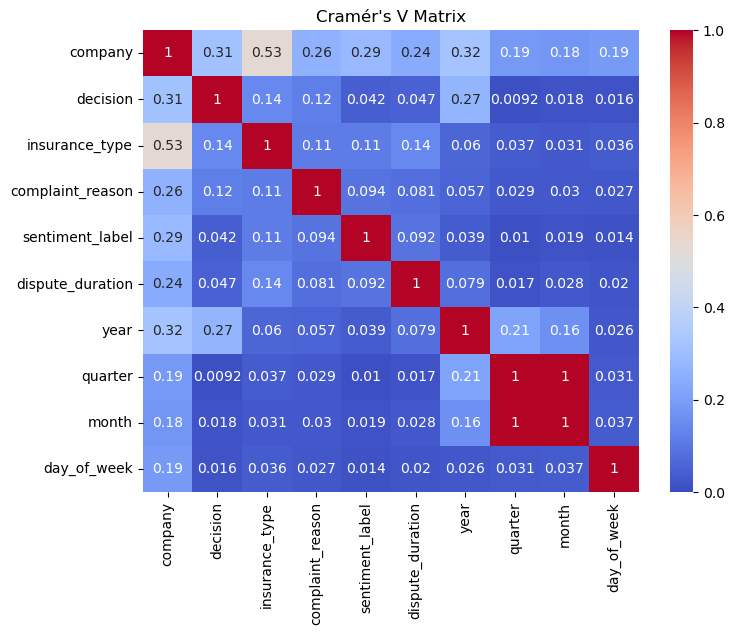

In [13]:
# Define a function to calculate Cramer's V coefficient
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

cramers_v_matrix = pd.DataFrame(index=categorical_data, columns=categorical_data)

# Calculate Cramer's V between each pair of features
for i in range(len(categorical_data)):
    for j in range(i, len(categorical_data)):
        feature1 = categorical_data[i]
        feature2 = categorical_data[j]
        cramers_v_matrix.loc[feature1, feature2] = cramers_v(data[feature1], data[feature2])
        cramers_v_matrix.loc[feature2, feature1] = cramers_v_matrix.loc[feature1, feature2]

# Converts the values in a matrix to numeric types
cramers_v_matrix = cramers_v_matrix.astype(float)

# Heat Map
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Matrix")
plt.show()

From above heatmap, we can find some patterns from the data since it provides a comprehensive overview of the association between categorical variables in the dataset.

I list some of interesting things here:

- **High Correlation (Cramér's V > 0.5)**: 
    1. Company vs. Insurance Type (0.53): There is a strong correlation between the company and the type of insurance. This indicates that certain companies specialize in specific types of insurance products.
   
- **Moderate Correlation (0.1 < Cramér's V ≤ 0.5):**: 
    1. Company vs. Year (0.32): A moderate correlation between the company and the year indicates that the dataset might contain temporal trends related to specific companies.
    2. Company vs. Decision (0.31): There is a moderate correlation between the company and the decision (upheld or not upheld). This suggests that certain companies have a higher likelihood of complaints being upheld or not upheld. This could be explored further.
    3. Company vs. Sentiment Label (0.29): The correlation between the company and the sentiment label suggests that the company's identity might influence the sentiment of the complaints.
    4. Decision vs. Year (0.27): This correlation implies that the decision outcomes may vary over different years.
    5. Decision vs. Insurance Type (0.14): There is a moderate correlation between the decision and the type of insurance. This could mean that certain types of insurance policies are more prone to having complaints upheld or not.
    6. Insurance Type vs. Dispute Duration (0.14): A moderate correlation between the insurance type and the dispute duration indicates that different types of insurance may require different time periods to handle.
    
Overall, there is a strong correlation between the variable `company` and most other variables. We can prioritize analyzing this variable in subsequent analyses. Additionally, the **insurance product type** and the **cause of the complaint** are also important variables to study. We can further analyze these variables in conjunction with the variable `decision` , sentiment-related variables, and dispute duration variables over years. This comprehensive analysis can help uncover existing insights and guide product modifications and improvements, ultimately enhancing customer satisfaction.

We found that the extracted time variables, such as `month`, `quarter` and `day_of_week`, have low correlation with other variables except for `company`. Therefore, these two variables might not hold much analytical value. However, the variable `year` is important to study the target variable `decision`.


### Between Categorical and Numerical Variables

For the relationship between numerical variables and categorical variables, we used ANOVA (Analysis of Variance) to test whether there are significant differences in the numerical variables across the different categories of the categorical variables.

In [17]:
sub_categorical_data = ['decision','insurance_type','complaint_reason','dispute_duration','year','quarter','month','day_of_week']

# Numerical and categorical variables correlation
results = []

for num_col in numerical_data:
    for cat_col in sub_categorical_data:
        groups = [data[num_col][data[cat_col] == val] for val in data[cat_col].unique()]
        # Check if each group has enough data points
        if all(len(group) > 1 for group in groups):
            f_stat, p_value = f_oneway(*groups)  # Use ANOVA
            test_type = 'ANOVA'
        else:
            f_stat = np.nan
            p_value = np.nan
            test_type = 'N/A'
        
        reject = 'Reject' if p_value < 0.01 else 'Fail to Reject'

        results.append({
            'Numerical Variable': num_col,
            'Categorical Variable': cat_col,
            'F-statistic': f_stat,
            'p-value': p_value,
            'Test Type': test_type,
            'Reject Null Hypothesis (1%)': reject
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

,Numerical Variable,Categorical Variable,F-statistic,p-value,Test Type,Reject Null Hypothesis (1%)
0,sentiment_score,decision,45.582430,1.486949e-11,ANOVA,Reject
1,sentiment_score,insurance_type,102.074677,0.000000e+00,ANOVA,Reject
2,sentiment_score,complaint_reason,41.506242,3.116548e-184,ANOVA,Reject
3,sentiment_score,dispute_duration,55.007241,1.840076e-35,ANOVA,Reject
4,sentiment_score,year,7.818128,1.977832e-08,ANOVA,Reject
5,sentiment_score,quarter,0.692612,5.564164e-01,ANOVA,Fail to Reject
6,sentiment_score,month,0.936081,5.039130e-01,ANOVA,Fail to Reject
7,sentiment_score,day_of_week,2.367713,2.743700e-02,ANOVA,Fail to Reject


The results can be interpreted as follows:

- **Decision**: With an F-statistic of 45.582430 and a p-value of approximately 1.49e-11, we reject the null hypothesis. This means there are significant differences in sentiment scores across different decision categories.
- **Insurance Type**: With an F-statistic of 102.074677 and a p-value of 0.0, we reject the null hypothesis. This indicates significant differences in sentiment scores across different insurance types.
- **Complaint Reason**: With an F-statistic of 41.506242 and a p-value of approximately 3.12e-184, we reject the null hypothesis. There are significant differences in sentiment scores across different complaint reasons.
- **Dispute Duration**: With an F-statistic of 55.007241 and a p-value of approximately 1.84e-35, we reject the null hypothesis. This shows significant differences in sentiment scores based on dispute duration.
- **Year**: With an F-statistic of 7.818128 and a p-value of approximately 1.98e-08, we reject the null hypothesis. There are significant differences in sentiment scores across different years.
- **Quarter**：  With an F-statistic of 0.0.6926 and a p-value of approximately 0.556, we fail to reject the null hypothesis. 
- **Month**: With an F-statistic of 0.936081 and a p-value of approximately 0.504, we fail to reject the null hypothesis. This means there are no significant differences in sentiment scores across different months.
- **Day of Week**: With an F-statistic of 2.367713 and a p-value of approximately 0.0274, we fail to reject the null hypothesis at a 1% significance level. This indicates that there are no significant differences in sentiment scores across different days of the week, though it is close to significance at a higher threshold.

In summary, most of the categorical variables show a significant relationship with sentiment scores, except for `quarter`, `month` and `day_of_week`.

## Differences in FOS Considerations for Upheld and Not upheld

**What actions lead to a successful claim(Upheld)/unsuccessful claim(Not Upheld) with the FOS? **

We used the ‘What I’ve decided – and why’ paragraph to find the keywords that are most likely to appear in the upheld and not upheld categories, and made a word cloud diagram.

In [ ]:
# An extended dictionary of common wrong words and their corresponding correct words
corrections = {
    "mecnic": "mechanic",
    "intruption": "interruption",
    "mical": "medical",
    "neighbour": "neighbor",
    "deliv": "deliver",
    "psonal": "personal",
    "mium": "premium",
    "nuis": "nuisance",
    "daught": "daughter",
    "situ": "situation",
    "mech": "mechanic",
    "pay feel": "pay fee",
    "assur": "assurance",
    "efully": "fully",
    "indicat": "indicate",
    "intnal": "internal",
    "benefit": "benefits",
    "roof": "roofing",
    "memb": "member",
    "answ": "answer",
    "evidence": "evidence",
    "evidenc": "evidence",
    "misresntation": "misrepresentation",
    "svice": "service"
}

# An expanded list of useless high-frequency words or phrases
manual_high_freq_words = ['ha','wa','towards','ergo','cosa','ch','contains','nevertheless',
                        'claim','considered','miss','term','fair','reasonable','made','see',
                        'insurance','pcp','say','sll','nh','aviv','uki','condition','complaint',
                        'whether','axa','circumstance','evidence','ow','nic','kb','pathic','built',
                        'hoc','cma','pc','opon','caused','sling','keep','call','titan','ly',
                        'available','wp','qi','ur','finding','thought','agree','accepted',
                        'ard','kiten','provide','provided','think','sum','covered','renel',
                        'floor','decision','pay','event','policy','storm','acted','decide']

def correct_and_remove(text, corrections, high_freq_phrases):
    if pd.isna(text):
        return text
    # Replace misspellings
    for wrong, right in corrections.items():
        pattern = re.compile(re.escape(wrong), re.IGNORECASE)
        text = pattern.sub(right, text)
    # Remove high frequency words
    for phrase in high_freq_phrases:
        pattern = re.compile(re.escape(phrase), re.IGNORECASE)
        text = pattern.sub('', text)
    return text

# Apply the function to the column
data['What I’ve decided – and why'] = data['What I’ve decided – and why'].apply(lambda x: correct_and_remove(x, corrections, manual_high_freq_words))


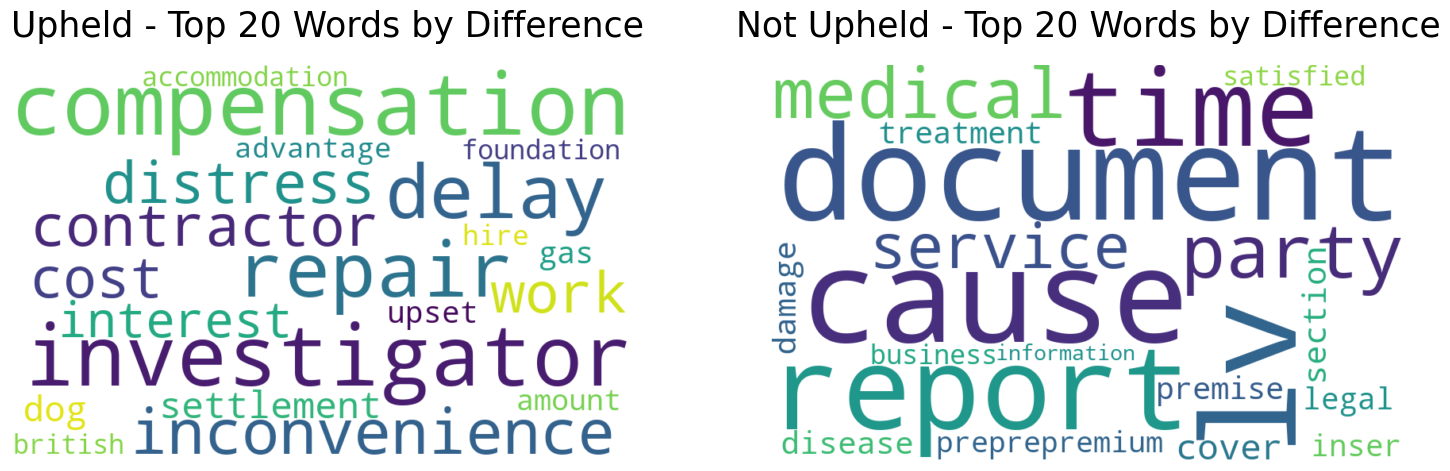

In [70]:
# Replace NaN values with empty strings
upheld_text = data[data['decision'] == 'Upheld']['What I’ve decided – and why'].fillna('')
not_upheld_text = data[data['decision'] == 'Not upheld']['What I’ve decided – and why'].fillna('')

# Vectorize the text to count word frequencies
vectorizer = CountVectorizer(ngram_range=(1, 1))

# Fit and transform the Upheld text
upheld_counts = vectorizer.fit_transform(upheld_text)
# Transform the Not Upheld text using the same vectorizer
not_upheld_counts = vectorizer.transform(not_upheld_text)

# Get the vocabulary (words)
words = vectorizer.get_feature_names_out()

# Calculate word frequencies
upheld_word_freq = upheld_counts.toarray().sum(axis=0)
not_upheld_word_freq = not_upheld_counts.toarray().sum(axis=0)

# Create dictionaries for word frequencies
upheld_word_freq_dict = dict(zip(words, upheld_word_freq))
not_upheld_word_freq_dict = dict(zip(words, not_upheld_word_freq))

# Combine word frequency data into a DataFrame
word_freq = pd.DataFrame({
    'Upheld': upheld_word_freq_dict,
    'Not Upheld': not_upheld_word_freq_dict
}).fillna(0)

# Calculate the difference in word frequencies
word_freq['Difference'] = word_freq['Upheld'] - word_freq['Not Upheld']

# Find the top 20 words with the largest positive and negative differences
top_diff_words_upheld = word_freq.sort_values(by='Difference', ascending=False).head(20)
top_diff_words_not_upheld = word_freq.sort_values(by='Difference', ascending=True).head(20)

# Generate word clouds
upheld_wordcloud = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(top_diff_words_upheld['Difference'].to_dict())
not_upheld_wordcloud = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(top_diff_words_not_upheld['Difference'].to_dict())

# Plot the word clouds
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
axes[0].imshow(upheld_wordcloud, interpolation='bilinear')
axes[0].set_title('Upheld - Top 20 Words by Difference', fontsize=25, pad=20)
axes[0].axis('off')
axes[1].imshow(not_upheld_wordcloud, interpolation='bilinear')
axes[1].set_title('Not Upheld - Top 20 Words by Difference', fontsize=25, pad=20)
axes[1].axis('off')
plt.show()

In summary, when decisions are upheld, FOS focuses more on the customer's direct economic losses, inconvenience, emotional distress, and actual repair needs, with investigators' reports and findings playing a crucial role. When decisions are not upheld, FOS emphasizes the specific details of the event, the completeness and accuracy of evidence, the cause and responsible parties of the incident, as well as legal terms and time factors. These analyses indicate that FOS has different bases for supporting or not supporting complaints, reflecting their varied points of focus and considerations in different contexts. This information can help to understand the decision of FOS during the decision-making process.

## Company Analysis


Due to the large number of categories for companies, it is difficult to perform detailed classification analysis. Therefore, we conducted some simple analyses separately for companies. We identified the five companies with the highest number of complaints and their corresponding upheld and not upheld rates. Additionally, by sorting the upheld and not upheld rates, we found the five companies with the highest upheld rates and the five companies with the highest not upheld rates.

In [88]:
# Step 1: Calculate the total complaints, upheld complaints, and not upheld complaints for each company
company_complaint_stats = data.groupby('company')['decision'].value_counts().unstack().fillna(0)
company_complaint_stats['Total Complaints'] = company_complaint_stats.sum(axis=1)
company_complaint_stats['Upheld Rate (%)'] = (company_complaint_stats['Upheld'] / company_complaint_stats['Total Complaints']) * 100
company_complaint_stats['Not Upheld Rate (%)'] = (company_complaint_stats['Not Upheld'] / company_complaint_stats['Total Complaints']) * 100

# Step 2: Find the top 5 companies by complaint count
top_5_complaint_companies = company_complaint_stats.nlargest(5, 'Total Complaints')

# Step 3: Find the top 5 companies by upheld rate (excluding companies with less than 10 complaints to avoid skewed rates)
top_5_upheld_rate_companies = company_complaint_stats[company_complaint_stats['Total Complaints'] >= 10].nlargest(5, 'Upheld Rate (%)')

# Step 4: Find the top 5 companies by not upheld rate (excluding companies with less than 10 complaints to avoid skewed rates)
top_5_not_upheld_rate_companies = company_complaint_stats[company_complaint_stats['Total Complaints'] >= 10].nlargest(5, 'Not Upheld Rate (%)')

# Step 5: Create the summary table for top 5 complaint companies
summary_top_5_complaints = pd.DataFrame({
    'Top 5 Complaint Companies': top_5_complaint_companies.index,
    'Complaint Counts': top_5_complaint_companies['Total Complaints'],
    'Upheld Rate (%)': top_5_complaint_companies['Upheld Rate (%)'],
    'Not Upheld Rate (%)': top_5_complaint_companies['Not Upheld Rate (%)']
})

# Step 6: Create the summary table for top 5 upheld rate companies
summary_top_5_upheld = pd.DataFrame({
    'Top 5 Upheld Rate Companies': top_5_upheld_rate_companies.index,
    'Upheld Rate (%)': top_5_upheld_rate_companies['Upheld Rate (%)']
})

# Step 7: Create the summary table for top 5 not upheld rate companies
summary_top_5_not_upheld = pd.DataFrame({
    'Top 5 Not Upheld Rate Companies': top_5_not_upheld_rate_companies.index,
    'Not Upheld Rate (%)': top_5_not_upheld_rate_companies['Not Upheld Rate (%)']
})


In [89]:
summary_top_5_complaints

,Top 5 Complaint Companies,Complaint Counts,Upheld Rate (%),Not Upheld Rate (%)
company,,,,
Aviva Insurance Limited,Aviva Insurance Limited,2022.0,37.339268,62.660732
U K Insurance Limited,U K Insurance Limited,2010.0,32.736318,67.263682
AXA Insurance UK Plc,AXA Insurance UK Plc,1489.0,45.063801,54.936199
Ageas Insurance Limited,Ageas Insurance Limited,994.0,51.207243,48.792757
British Gas Insurance Limited,British Gas Insurance Limited,994.0,58.148893,41.851107


In [90]:
summary_top_5_upheld

,Top 5 Upheld Rate Companies,Upheld Rate (%)
company,,
East West Insurance Company Limited,East West Insurance Company Limited,100.000000
Strathearn Insurance Services Limited,Strathearn Insurance Services Limited,100.000000
Triton Insurance Brokers Ltd,Triton Insurance Brokers Ltd,96.969697
Europaische Reiseversicherung AG,Europaische Reiseversicherung AG,93.333333
Millennium Insurance Company Limited,Millennium Insurance Company Limited,93.333333


In [91]:
summary_top_5_not_upheld

,Top 5 Not Upheld Rate Companies,Not Upheld Rate (%)
company,,
Advisory Insurance Brokers Limited,Advisory Insurance Brokers Limited,92.307692
Allied World Assurance Company (Europe) dac,Allied World Assurance Company (Europe) dac,91.666667
Newline Insurance Company Limited,Newline Insurance Company Limited,90.000000
Sesame Limited,Sesame Limited,90.000000
Liverpool Victoria Financial Services Limited,Liverpool Victoria Financial Services Limited,89.130435


To understand the patterns among companies with the highest upheld and not upheld rates, we need to examine the specific data for these companies. 

In [92]:
# See the data of Haven Insurance Company Limited and DAS Legal Expenses Insurance Company Limited
east_data = data[data['company'] == 'East West Insurance Company Limited']
ad_data = data[data['company'] == 'Advisory Insurance Brokers Limited']

In [93]:
east_data[['company','decision','insurance_type','complaint_reason','sentiment_label']]

,company,decision,insurance_type,complaint_reason,sentiment_label
8604,East West Insurance Company Limited,Upheld,property insurance policy,"Poor Service, Bad Treatment",extremely negative
9053,East West Insurance Company Limited,Upheld,property insurance policy,"Poor Service, Refusing Claims, Bad Treatment, ...",mildly negative
9316,East West Insurance Company Limited,Upheld,building insurance policy,Poor Service,highly negative
9327,East West Insurance Company Limited,Upheld,property insurance policy,"Poor Service, Bad Treatment",highly negative
9328,East West Insurance Company Limited,Upheld,property insurance policy,"Poor Service, Bad Treatment",highly negative
9329,East West Insurance Company Limited,Upheld,property insurance policy,"Poor Service, Bad Treatment",highly negative
9330,East West Insurance Company Limited,Upheld,property insurance policy,"Poor Service, Bad Treatment",highly negative
9331,East West Insurance Company Limited,Upheld,property insurance policy,"Poor Service, Bad Treatment",highly negative
9332,East West Insurance Company Limited,Upheld,property insurance policy,"Poor Service, Bad Treatment",highly negative
9333,East West Insurance Company Limited,Upheld,property insurance policy,"Poor Service, Bad Treatment",highly negative


In [94]:
ad_data[['decision_id','company','decision','insurance_type','complaint_reason','sentiment_label']]

,decision_id,company,decision,insurance_type,complaint_reason,sentiment_label
15653,DRN-3902624,Advisory Insurance Brokers Limited,Not Upheld,home insurance policy,Other Combinations of Reasons,neutral
17180,DRN-3828723,Advisory Insurance Brokers Limited,Not Upheld,business insurance policy,"Poor Service, Refusing Claims, Bad Treatment",extremely negative
17908,DRN-3706340,Advisory Insurance Brokers Limited,Not Upheld,property insurance policy,"Poor Service, Policy Problem",extremely negative
17994,DRN-3688322,Advisory Insurance Brokers Limited,Not Upheld,building insurance policy,"Poor Service, Bad Treatment",neutral
20124,DRN-3429225,Advisory Insurance Brokers Limited,Not Upheld,car insurance policy,"Poor Service, Refusing Claims, Policy Problem",highly negative
20905,DRN-3420231,Advisory Insurance Brokers Limited,Not Upheld,car insurance policy,"Poor Service, Refusing Claims, Policy Problem",extremely negative
21012,DRN-3481341,Advisory Insurance Brokers Limited,Not Upheld,property insurance policy,"Poor Service, Policy Problem",neutral
21421,DRN-3408944,Advisory Insurance Brokers Limited,Not Upheld,property insurance policy,"Refusing Claims, Policy Problem",neutral
27713,DRN-4694864,Advisory Insurance Brokers Limited,Not Upheld,home insurance policy,"Poor Service, Refusing Claims, Policy Problem",extremely negative
28199,DRN-4728924,Advisory Insurance Brokers Limited,Not Upheld,business insurance policy,"Poor Service, Refusing Claims",neutral


For the company with a 100% upheld rate, East West Insurance Company Limited, I found that their service product types are simple, mainly focused on property. The reasons for complaints are also very similar, with customers generally experiencing negative emotions. However, for companies with a 92.3% not upheld rate, we observed that customer emotions are relatively less negative. Additionally, previous word cloud analyses showed that FOS considers customer distress and emotional factors when making support decisions. We hypothesize that FOS's decisions are related to the extent of the customer's losses.

In [95]:
data['company'].value_counts()

Aviva Insurance Limited                        2022
U K Insurance Limited                          2010
AXA Insurance UK Plc                           1489
British Gas Insurance Limited                   994
Ageas Insurance Limited                         994
                                               ... 
Telford-Reede Ltd                                 1
Health Net Services Limited                       1
Best Protect Online Limited                       1
Norton Insurance Brokers Ltd                      1
Mercedes-Benz Insurance Services UK Limited       1
Name: company, Length: 1025, dtype: int64

In [7]:
# Too many company categories that need to be reduced

# Count the number of complaints per company
company_counts = data['company'].value_counts()

# Companies with fewer than 20 complaints are classified as "other companies"
data['company'] = data['company'].apply(lambda x: x if company_counts[x] >= 20 else 'other company')

print(data['company'].value_counts())

other company                               2683
Aviva Insurance Limited                     2022
U K Insurance Limited                       2010
AXA Insurance UK Plc                        1489
British Gas Insurance Limited                994
                                            ... 
Acorn Insurance & Financial Services Ltd      21
Financial & Legal Insurance Company Ltd       20
Scottish Widows Limited                       20
Jelf Insurance Brokers Limited                20
ActiveQuote Limited                           20
Name: company, Length: 167, dtype: int64


## Product and Complaint Analysis

In this section, we primarily analyzed content related to insurance products. 

- First, we plotted the distribution and overall quantity trends of relevant variables under both upheld and not upheld decisions. 

- Second, we created stacked bar charts for insurance types and sentiment classifications under upheld and not upheld decisions to illustrate how different insurance types and sentiment categories contribute to decision outcomes. 

- Third, we calculated the proportion of each complaint reason for every insurance type and summarized the results in a table, providing Simply Business with insights to make targeted adjustments to their products and services based on prevalent complaint reasons. 

- Finally, we drew pie charts showing the distribution of insurance products across different dispute duration categories, clearly depicting how different insurance products are associated with varying lengths of dispute resolution times.

Now, let us have a look at the distribution plots.

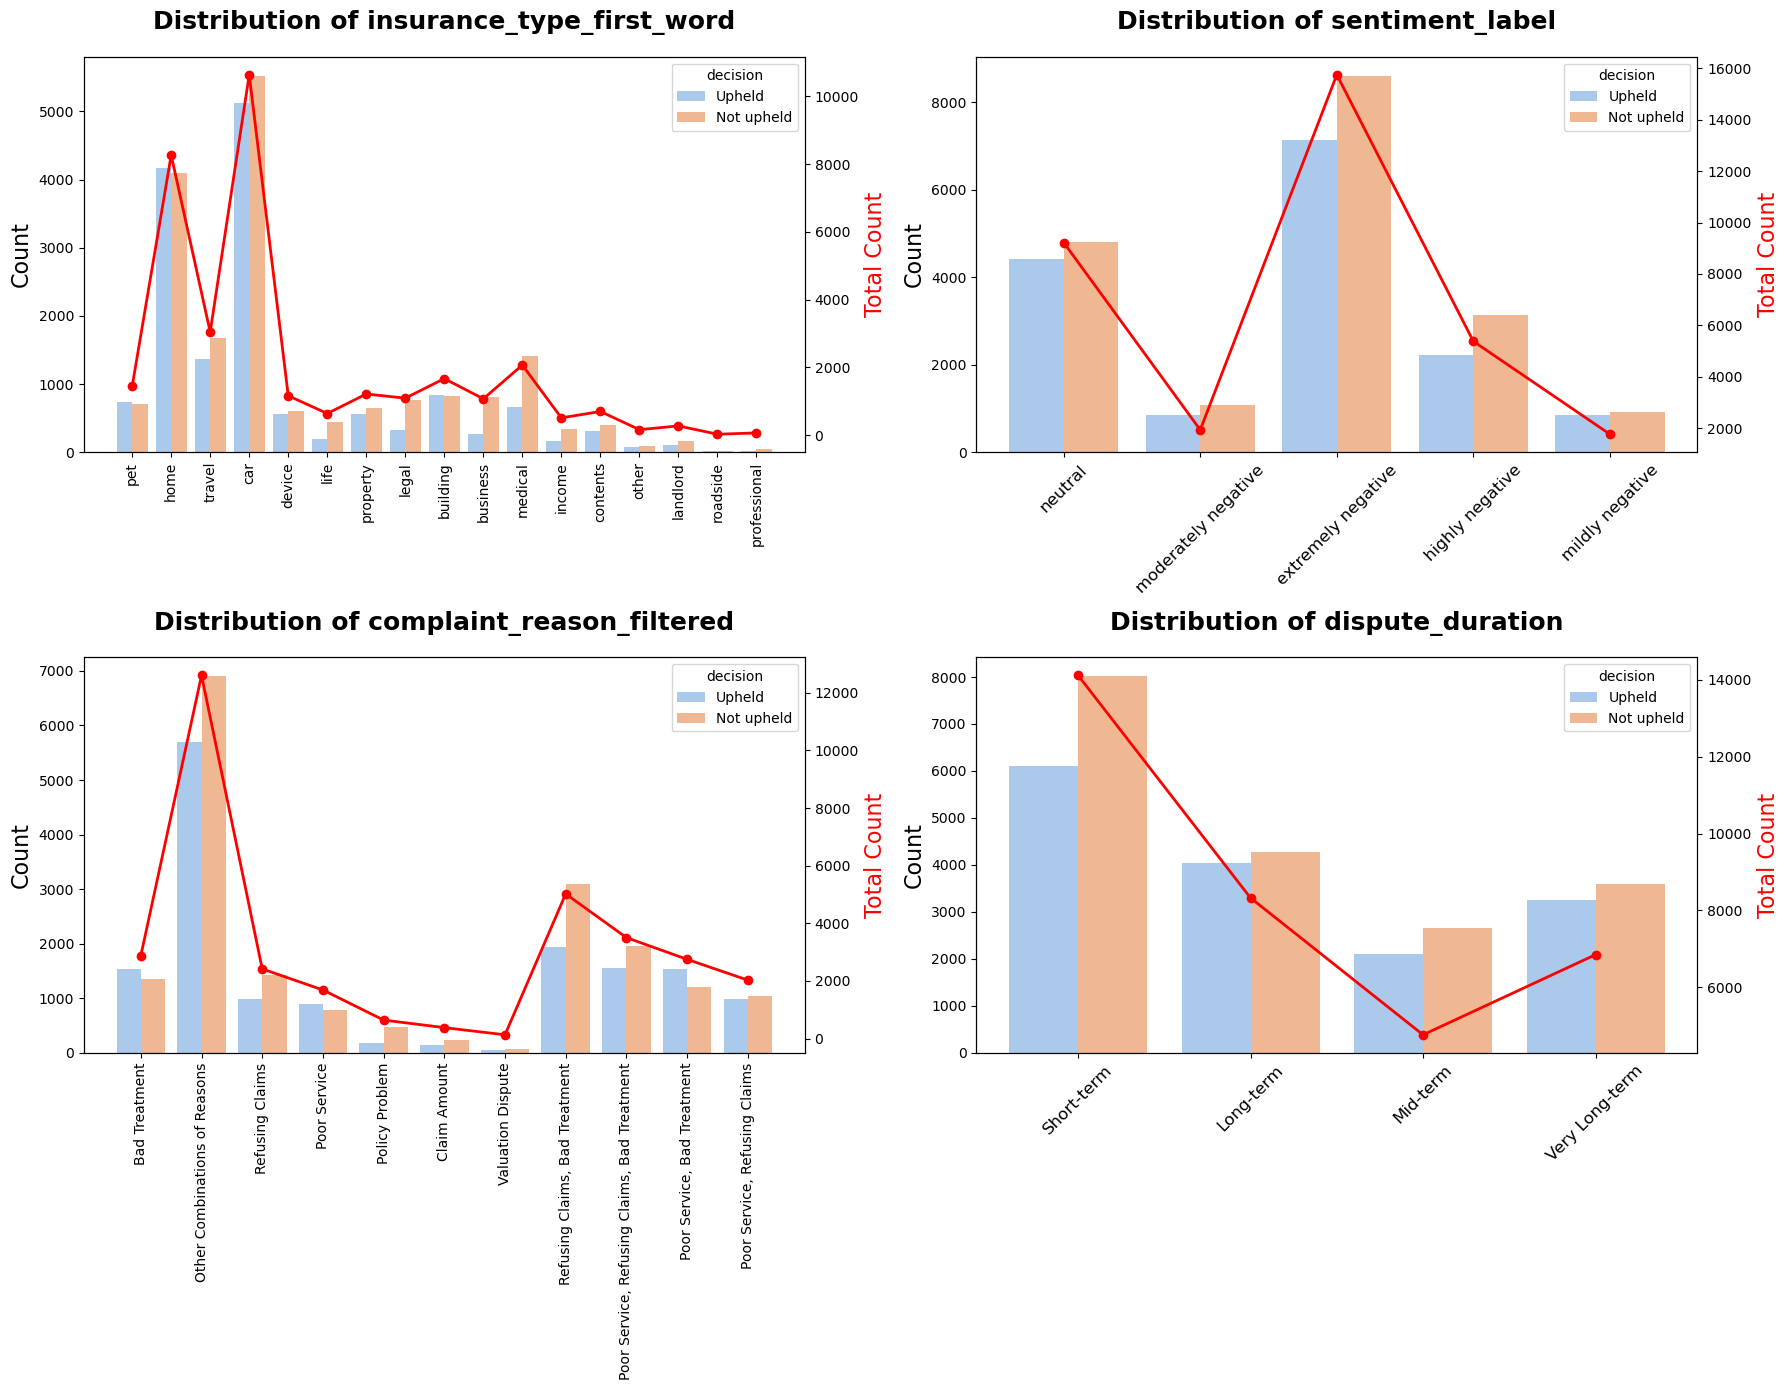

In [8]:
# Keep only the first word of the insurance product type
data['insurance_type_first_word'] = data['insurance_type'].apply(lambda x: x.split()[0])

# Get the top four combination reasons
reason_counts = data['complaint_reason'].value_counts()
top_combination_reasons = reason_counts[reason_counts.index.str.contains(',')].head(4).index.tolist()
single_reasons = reason_counts[~reason_counts.index.str.contains(',')].index.tolist()

# Create a new column to handle combination reasons
data['complaint_reason_filtered'] = data['complaint_reason'].apply(lambda x: x if x in single_reasons + top_combination_reasons else 'Other Combinations of Reasons')

# Separate single category reasons and combination reasons
sorted_single_reasons = reason_counts.loc[single_reasons].index.tolist()
sorted_combination_reasons = top_combination_reasons + ['Other Combinations of Reasons']

# Ensure the order of `complaint_reason_filtered` is single category reasons followed by combination reasons
categories = sorted_single_reasons + sorted_combination_reasons
categories = list(dict.fromkeys(categories))  # Remove duplicate categories

data['complaint_reason_filtered'] = pd.Categorical(data['complaint_reason_filtered'], categories=categories, ordered=True)


# Function to plot category distribution with order and labels
def plot_category_distribution(data, feature, ax):
    # Plot bar chart
    sns.countplot(data=data, x=feature, hue='decision', ax=ax, palette="pastel")
    ax.set_title(f'Distribution of {feature}', fontsize=18, fontweight='bold', pad=20)  # Add title with padding
    ax.set_xlabel('', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    
    # Rotate labels for readability
    if feature in ['insurance_type_first_word', 'complaint_reason_filtered']:
        ax.tick_params(axis='x', rotation=90, labelsize=10)  # Rotate labels and adjust font size
    else:
        ax.tick_params(axis='x', rotation=45, labelsize=12)  # Rotate other labels and adjust font size
    
    # Calculate total count for each category
    total_counts = data[feature].value_counts().reindex(data[feature].cat.categories if hasattr(data[feature], 'cat') else data[feature].unique()).fillna(0)
    
    # Plot total count line on the same chart
    ax2 = ax.twinx()
    ax2.plot(total_counts.index, total_counts.values, color='red', marker='o', linestyle='-', linewidth=2)
    ax2.set_ylabel('Total Count', fontsize=16, color='red')
    ax2.tick_params(axis='y', labelsize=10)
    
    # Align x-axis of line chart and bar chart
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
    
fig1, axes1 = plt.subplots(2, 2, figsize=(18, 14))  # 2 rows, 2 columns subplots
axes1 = axes1.flatten()

selected_categorical_data1 = ['insurance_type_first_word', 'sentiment_label', 'complaint_reason_filtered', 'dispute_duration']

# Plot each selected categorical variable
for i, feature in enumerate(selected_categorical_data1):
    plot_category_distribution(data, feature, axes1[i])

# Adjust layout
plt.tight_layout()
plt.show()

In these above four distribution charts, the red line represents the total number of complaints, and the bar charts are divided into upheld and not upheld categories for each type.

First, it is clear which insurance products have a higher number of not upheld complaints, such as medical and business insurance. It is also evident that car and home insurance have the highest number of complaints overall.

Second, we find that complaint reasons are often composed of combined causes. Among single reasons, bad treatment, poor service, and refusing claims are predominant, and combinations of these reasons are quite common.

Third, customer complaint sentiments show a significant polarization, with most complaints being either extremely negative or neutral. Lastly, the majority of disputes are short-term.

Next, let’s look at the relationship between product types and customer sentiment. The percentage on the graph is the proportion of extremely negative types.

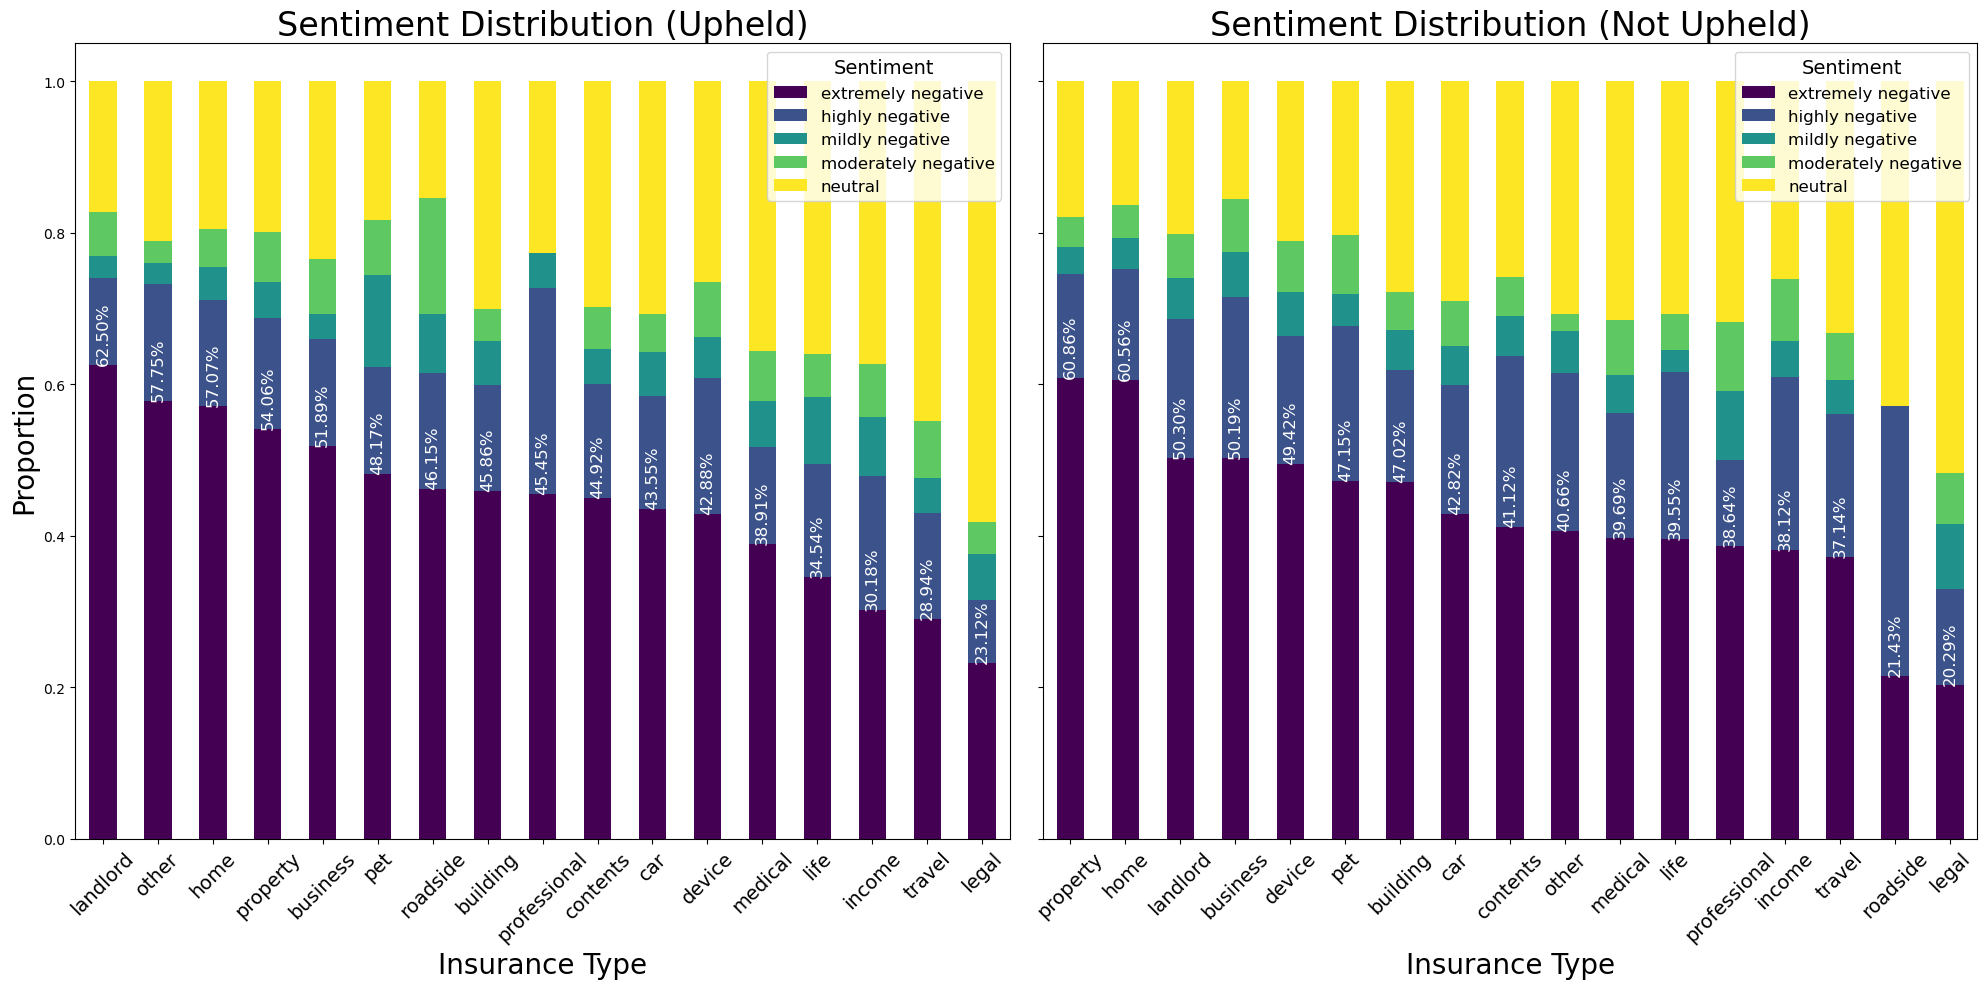

In [29]:
# Create crosstabs
crosstab_upheld = pd.crosstab(data[data['decision'] == 'Upheld']['insurance_type_first_word'], 
                              data[data['decision'] == 'Upheld']['sentiment_label'], normalize='index')
crosstab_not_upheld = pd.crosstab(data[data['decision'] == 'Not upheld']['insurance_type_first_word'], 
                                  data[data['decision'] == 'Not upheld']['sentiment_label'], normalize='index')

# Sort by the proportion of extremely negative sentiment
sorted_upheld = crosstab_upheld.sort_values(by='extremely negative', ascending=False)
sorted_not_upheld = crosstab_not_upheld.sort_values(by='extremely negative', ascending=False)

# Plot stacked bar charts
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Upheld decisions plot
sorted_upheld.plot(kind='bar', stacked=True, ax=axes[0], colormap='viridis', legend=True)
axes[0].set_title('Sentiment Distribution (Upheld)', fontsize=24)
axes[0].set_xlabel('Insurance Type', fontsize=20)
axes[0].set_ylabel('Proportion', fontsize=20)
axes[0].tick_params(axis='x', rotation=45, labelsize=14)
axes[0].legend(title='Sentiment', fontsize=12, title_fontsize=14)

# Not upheld decisions plot
sorted_not_upheld.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis', legend=True)
axes[1].set_title('Sentiment Distribution (Not Upheld)', fontsize=24)
axes[1].set_xlabel('Insurance Type', fontsize=20)
axes[1].tick_params(axis='x', rotation=45, labelsize=14)
axes[1].legend(title='Sentiment', fontsize=12, title_fontsize=14)

# Annotate the proportion of extremely negative sentiment at the top of each bar
def annotate_extreme_negative(ax, crosstab):
    for i, label in enumerate(crosstab.index):
        height = crosstab.loc[label, 'extremely negative']
        ax.text(i, height, f'{height:.2%}', ha='center', va='bottom', fontsize=12, color='white', rotation=90)

# Annotate both plots
for ax, crosstab in zip(axes, [sorted_upheld, sorted_not_upheld]):
    annotate_extreme_negative(ax, crosstab)

plt.tight_layout()
plt.show()

From this stacked bar chart, we can derive the following analysis and insights:

- Insurance Types with High Proportion of Extremely Negative Sentiment:

    - For "Upheld" decisions, the insurance types with the highest proportion of extremely negative sentiment are landlord (62.50%), other (57.75%) and home (57.07%).
    - For "Not upheld" decisions, the insurance types with the highest proportion of extremely negative sentiment are property (60.86%), home (60.56%) and landlord (50.30%).
    - The high proportion of extremely negative sentiment reflects customer dissatisfaction with these products. However, regarding FOS's decisions, further analysis is needed to check our previous hypothesis that extreme sentiment might influence FOS to uphold the complaint.
    
- Insurance Types with Low Proportion of Extremely Negative Sentiment:

    - For "Upheld" decisions, the insurance types with the lowest proportion of extremely negative sentiment are legal (23.12%) and travel (28.94%).
    - For "Not upheld" decisions, the insurance types with the lowest proportion of extremely negative sentiment are legal (20.29%) and roadside (21.43%).
    - This might indicate that customers have fewer complaints or relatively milder emotions towards these insurance types.
    
- Relationship Between Sentiment and Decisions:

    - High proportions of extremely negative sentiment do not always mean that the complaints will be upheld by FOS. For example, while home insurance has a high proportion of extremely negative sentiment in "Not upheld" decisions (60.56%), it also has a high proportion in "Upheld" decisions (57.07%). This suggests that, despite significant dissatisfaction, FOS does not always support these complaints, possibly indicating that many complaints are unreasonable.
    - For roadside insurance, the proportion of extremely negative sentiment in "Upheld" decisions is 46.15%, while in "Not upheld" decisions, it is 21.43%. This indicates that a considerable portion of roadside insurance complaints are supported by FOS, reflecting that these complaints are reasonable and well-founded. This aligns with our previous hypothesis that negative customer sentiment can positively influence FOS's decision to uphold a complaint.

Overall, this chart shows the sentiment distribution across different insurance types, revealing the level of customer dissatisfaction and its relationship with FOS decisions. Extremely negative sentiments do not always lead to upheld decisions, which varies by insurance type, while some types have relatively mild complaints.

Now we want to examine the specific reasons for customer complaints for each insurance type.

In [30]:
# Extract single category complaint reasons and remove combined categories
single_reasons = data['complaint_reason'].apply(lambda x: x.split(', ')).explode().value_counts().index
single_reasons = [reason for reason in single_reasons if 'Other' not in reason]

# Find the top 5 most common combined categories
top_combined_reasons = data['complaint_reason'].value_counts().index[:5]

# Remove duplicate reasons
reasons = list(single_reasons) + [reason for reason in top_combined_reasons if reason not in single_reasons]

# Filter data to retain only the desired complaint reasons
filtered_data = data[data['complaint_reason'].isin(reasons)]

# Create a DataFrame containing each insurance type, complaint reason, and their proportions
crosstab = pd.crosstab(filtered_data['insurance_type_first_word'], filtered_data['complaint_reason'], normalize='index')

# Convert data to wide format
crosstab = crosstab.reset_index()

# Format numbers as percentages, retaining one decimal place
crosstab.iloc[:, 1:] = crosstab.iloc[:, 1:].applymap(lambda x: f"{x:.1%}")

# Rename 'insurance_type_first_word' column
crosstab = crosstab.rename(columns={'insurance_type_first_word': 'Insurance Type'})

# Rearrange columns
new_column_order = ['Insurance Type'] + single_reasons + [reason for reason in top_combined_reasons if reason not in single_reasons]
crosstab = crosstab.reindex(columns=new_column_order)

crosstab


complaint_reason,Insurance Type,Bad Treatment,Refusing Claims,Poor Service,Policy Problem,Claim Amount,Valuation Dispute,"Refusing Claims, Bad Treatment","Poor Service, Refusing Claims, Bad Treatment",Other Combinations of Reasons,"Poor Service, Bad Treatment"
0,building,23.1%,6.8%,3.4%,1.4%,1.1%,0.0%,24.7%,21.7%,5.8%,12.2%
1,business,5.6%,14.8%,2.8%,4.8%,0.4%,0.1%,45.9%,12.6%,8.6%,4.2%
2,car,13.8%,9.2%,10.6%,2.5%,1.5%,1.9%,14.9%,10.8%,21.5%,13.2%
3,contents,9.7%,12.6%,4.2%,3.3%,0.7%,0.0%,27.0%,21.5%,11.7%,9.3%
4,device,13.1%,12.1%,14.2%,4.3%,2.5%,0.0%,14.0%,12.1%,12.7%,15.1%
5,home,13.8%,7.7%,10.9%,1.2%,0.9%,0.1%,18.0%,22.5%,8.5%,16.5%
6,income,6.1%,17.7%,2.1%,11.4%,0.8%,0.0%,50.5%,3.7%,6.1%,1.6%
7,landlord,20.1%,5.4%,2.7%,4.9%,0.0%,0.0%,25.0%,29.9%,4.3%,7.6%
8,legal,17.2%,6.6%,1.0%,2.2%,0.3%,0.0%,31.4%,22.2%,2.7%,16.5%
9,life,11.3%,11.5%,3.0%,9.8%,0.8%,0.0%,42.3%,5.1%,13.0%,3.4%


For the product types, we also want to explore whether there are interesting patterns between them and the time period for disputes. We used a pie chart to show this relationship, as shown below.

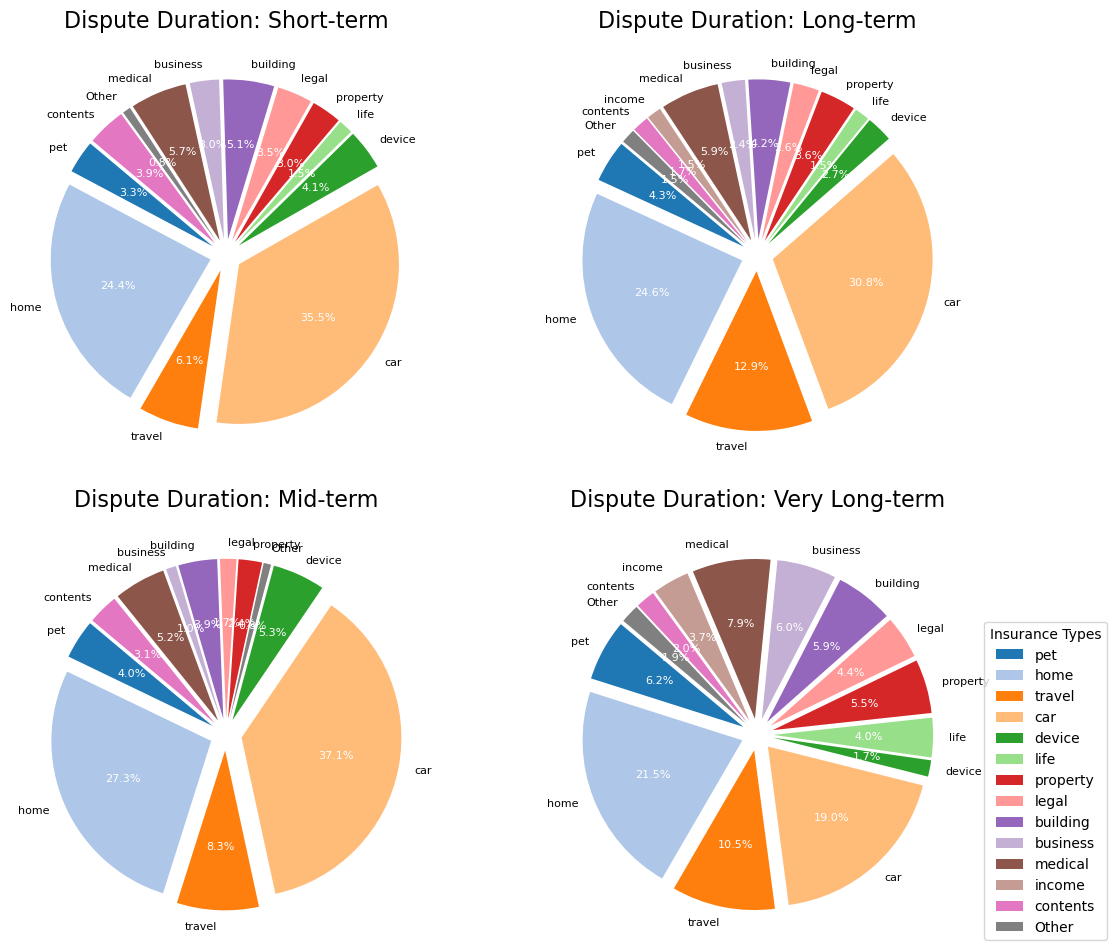

In [32]:
# Get all unique insurance types
insurance_types = data['insurance_type_first_word'].unique()

# Use a suitable colormap, such as 'tab20', which provides more colors
colors = plt.get_cmap('tab20')(range(len(insurance_types)))

# Initialize color mapping
color_map = {insurance: colors[i] for i, insurance in enumerate(insurance_types)}

# Define a threshold for less than 1%
threshold = 0.01

# Plot pie charts
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Calculate the distribution of insurance types for each dispute duration
for ax, duration in zip(axs.flatten(), data['dispute_duration'].unique()):
    filtered_data = data[data['dispute_duration'] == duration]
    insurance_counter = Counter(filtered_data['insurance_type_first_word'])
    
    # Calculate total count
    total = sum(insurance_counter.values())
    
    # Ensure each insurance type has a color
    labels = []
    sizes = []
    for insurance in insurance_types:
        if insurance_counter[insurance] / total >= threshold:
            labels.append(insurance)
            sizes.append(insurance_counter[insurance])
        else:
            if 'Other' in labels:
                sizes[-1] += insurance_counter[insurance]
            else:
                labels.append('Other')
                sizes.append(insurance_counter[insurance])
    
    color_list = [color_map[insurance] if insurance in color_map else 'grey' for insurance in labels]
    
    # Use explode to separate the pie slices
    explode = [0.1 if size > 0 else 0 for size in sizes]

    # Plot pie chart
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=color_list, explode=explode, startangle=140)
    
    for text in texts:
        text.set_fontsize(8)
    for autotext in autotexts:
        autotext.set_fontsize(8)
        autotext.set_color('white')
    
    ax.set_title(f'Dispute Duration: {duration}', fontsize=16, pad=20)

# Add a legend
plt.legend(wedges, labels, title="Insurance Types", bbox_to_anchor=(1.05, 0.8), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

Analyzing this set of pie charts, which depict the distribution of insurance types across different dispute durations, several key points can be highlighted:

1. In insurance disputes, car insurance, home insurance, and travel insurance account for the majority of disputes. Car insurance dominates the mid-term and short-term disputes, home insurance is evenly distributed across all durations, and travel insurance has a higher proportion in long-term and very long-term disputes compared to short-term and mid-term disputes.

2. For very long-term disputes, the proportion of car insurance significantly decreases, while pet, business, building, life, and income insurance show a noticeable increase. This indicates that these types of insurance are more prone to long-term disputes. Device and contents insurance have a very low proportion in very long-term disputes, suggesting that these types of insurance require a shorter time to resolve.


From these insights, Simply Business can optimize car insurance claims processes to reduce resolution times, improve handling of home insurance disputes to minimize long-term cases, and streamline travel insurance processes to address complexities and delays. Special attention should be given to pet, business, building, life, and income insurance to reduce long-term disputes. Additionally, successful practices from the efficient handling of device and contents insurance can be applied to other insurance types. This may relate to the nature of the products themselves, but by analyzing these quicker-resolving categories, dispute processing times can be accelerated. This will enhance dispute resolution processes, leading to higher customer satisfaction and operational efficiency.

## Time-related Variable Analysis

This section also can be divided into 3 parts:

- **Distribution Change Chart for Time-Related Variables**: This analysis shows the distribution of insurance-related variables over different years, helping to identify trends and patterns over time.

- **Line Chart of Each Insurance Product's Changes Over Time**: By plotting the change in the number of complaints for each type of insurance product over different years, insurance companies can understand which products had significant increases or decreases in complaints in certain years.

- **Line Chart of Customer Complaint Sentiments Over Years**: This analysis tracks the changes in customer complaint sentiments over different years, identifying trends in sentiment fluctuations. It helps insurance companies improve customer service and product design.

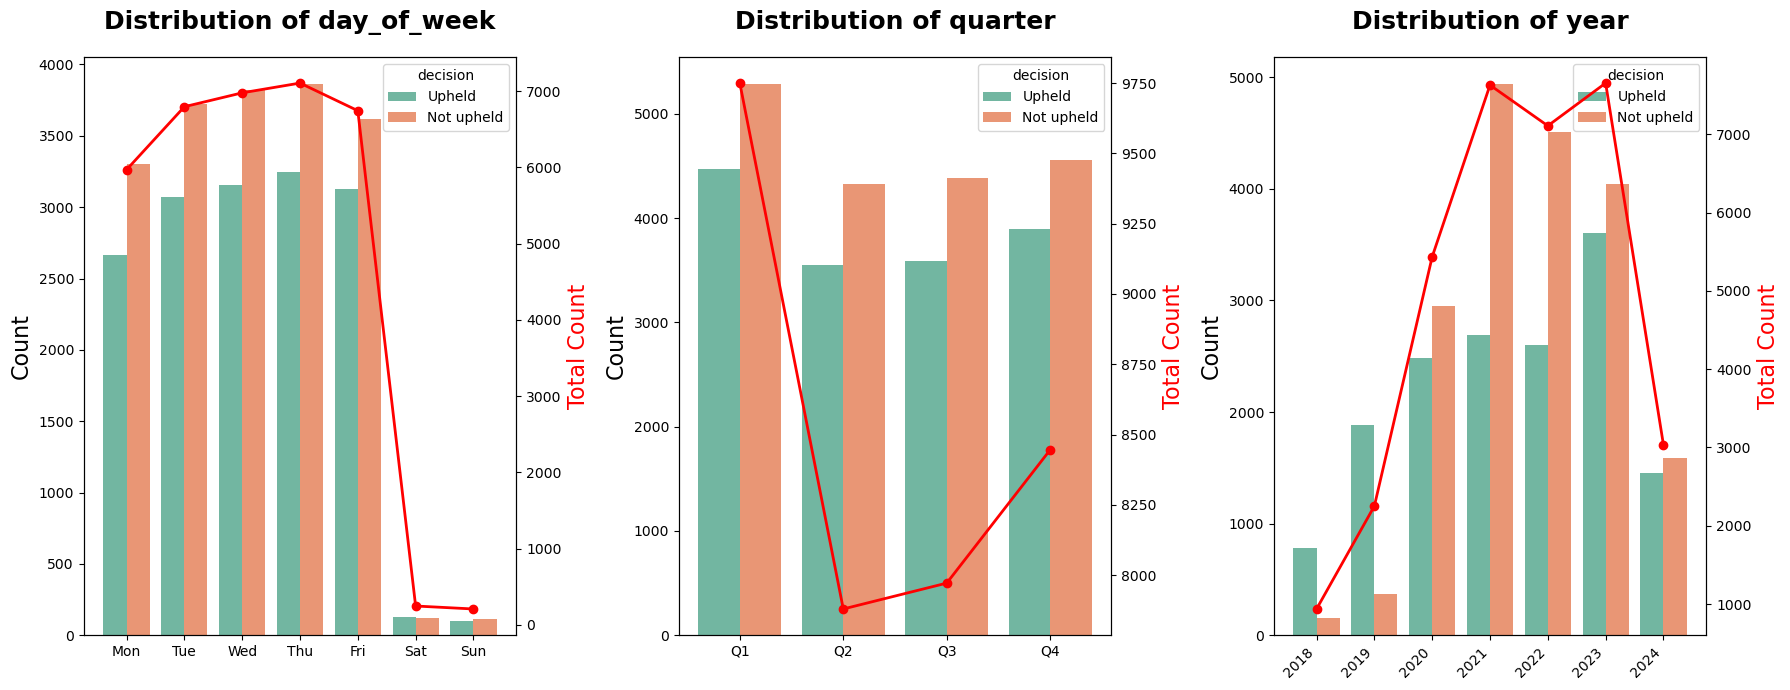

In [10]:
# Ensure the correct order for years and days of the week
years_order = sorted(data['year'].unique())
data['year'] = pd.Categorical(data['year'], categories=years_order, ordered=True)

days_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
data['day_of_week'] = data['date'].dt.day_name().str[:3]
data['day_of_week'] = pd.Categorical(data['day_of_week'], categories=days_order, ordered=True)

# Ensure the correct order for quarters, independent of year
data['quarter'] = data['date'].dt.quarter
quarters_order = [1, 2, 3, 4]
data['quarter'] = pd.Categorical(data['quarter'], categories=quarters_order, ordered=True)

# Function to plot the distribution of time-related variables
def plot_time_related_distribution(data, feature, ax):
    # Plot bar chart
    sns.countplot(data=data, x=feature, hue='decision', ax=ax, palette="Set2")
    ax.set_title(f'Distribution of {feature}', fontsize=18, fontweight='bold', pad=20)  # Add title with padding
    ax.set_xlabel('', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    
    # Rotate labels for readability
    if feature == 'year':
        years_order = sorted(data['year'].unique())
        ax.set_xticks(range(len(years_order)))
        ax.set_xticklabels(years_order, rotation=45, ha='right', fontsize=10)
    elif feature == 'quarter':
        quarter_labels = ['Q1', 'Q2', 'Q3', 'Q4']
        ax.set_xticks(range(4))
        ax.set_xticklabels(quarter_labels, fontsize=10)
    elif feature == 'day_of_week':
        ax.set_xticks(range(7))
        ax.set_xticklabels(days_order, fontsize=10)
    
    # Calculate total count for each category
    total_counts = data[feature].value_counts().reindex(data[feature].cat.categories if hasattr(data[feature], 'cat') else data[feature].unique()).fillna(0)
    
    # Plot total count line on the same chart
    ax2 = ax.twinx()
    if feature == 'year':
        ax2.plot(range(len(years_order)), total_counts.values, color='red', marker='o', linestyle='-', linewidth=2)
    elif feature == 'quarter':
        ax2.plot(range(4), total_counts.values, color='red', marker='o', linestyle='-', linewidth=2)
    elif feature == 'day_of_week':
        ax2.plot(range(7), total_counts.values, color='red', marker='o', linestyle='-', linewidth=2)
    ax2.set_ylabel('Total Count', fontsize=16, color='red')
    ax2.tick_params(axis='y', labelsize=10)
    
    # Align x-axis of line chart and bar chart
    ax2.set_xticks(ax.get_xticks())
    if feature == 'year':
        ax2.set_xticklabels(years_order, rotation=45, ha='right', fontsize=14)
    elif feature == 'quarter':
        ax2.set_xticklabels(quarter_labels, fontsize=14)
    elif feature == 'day_of_week':
        ax2.set_xticklabels(days_order, fontsize=14)

# Second set of charts: 'day_of_week', 'quarter', 'year'
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 7))  # 1 row, 3 columns subplots
axes2 = axes2.flatten()

selected_categorical_data2 = ['day_of_week', 'quarter', 'year']

# Plot each selected categorical variable
for i, feature in enumerate(selected_categorical_data2):
    plot_time_related_distribution(data, feature, axes2[i])

# Adjust layout
plt.tight_layout()
plt.show()

From the above distribution of time variables, it can be seen that:

- Distribution by Day of the Week (Left Chart):
    - Most complaints occur on weekdays (Monday to Friday), with a significant drop in complaints over the weekend.
    - The distribution trends for Upheld and Not upheld decisions are similar.
    - The overall trend shows a peak in complaints from Wednesday to Friday.
    
- Distribution by Quarter (Middle Chart):
    - The number of complaints is relatively balanced across each quarter, with slightly higher volumes in Q1 and Q4.
    - The distribution of Upheld and Not upheld decisions is also balanced, with no significant quarterly differences.
    - The total number of complaints in Q2 is slightly lower than in other quarters.
    
- Distribution by Year (Right Chart):
    - The volume of complaints increased annually from 2019 to 2023, with a decrease in 2024, likely because the data is only up to July 11.
    - The proportion of Upheld decisions was higher before 2020, but each year after, Not upheld decisions significantly outnumbered Upheld ones.

**Recommendations for Insurance Companies Based on Time Series Analysis**:

First, ensure sufficient resources are available to handle peak complaint periods, especially from Wednesday to Friday during weekdays. Develop specific handling strategies for the high complaint volumes in Q1 and Q4, allocating resources effectively to ensure efficient resolution of customer issues and improve service levels.

Second, address the significant increase in the proportion of Not upheld decisions by FOS after 2019. This may be due to FOS adjusting its processing procedures and standards, or possibly due to the insurance company's marketing and customer service creating overly high customer expectations that do not align with actual policy or contract terms, resulting in unsupported complaints. This situation can lead to decreased customer satisfaction, especially among those who believe their complaints are reasonable but are not supported.

Therefore, insurance companies should enhance customer understanding of their products, particularly regarding the terms and conditions, to help customers have a clearer understanding before lodging complaints. This can prevent misunderstandings and reduce the number of unsupported complaints.

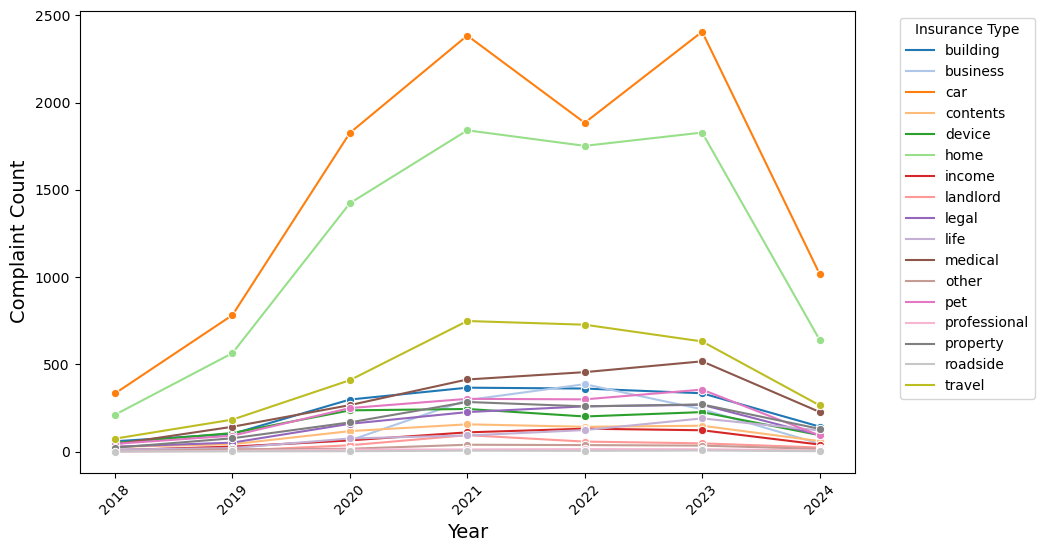

In [37]:
# Number of complaints by year and type of insurance
yearly_complaints = data.groupby(['year', 'insurance_type_first_word']).size().reset_index(name='complaint_count')

# Plot the trend of each insurance type over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_complaints, x='year', y='complaint_count', hue='insurance_type_first_word', marker='o', palette='tab20')

# Set the chart title and label
# plt.title('Yearly Complaints Trend by Insurance Type', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Complaint Count', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Insurance Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

From the line chart showing the changes in insurance types over the years, it is evident that car and home insurance complaints saw a significant increase between 2019 and 2020, while travel and medical insurance complaints had a smaller increase.

Based on these findings, insurance companies should take measures to focus on car and home insurance:

1. **Resource Allocation**:
   - Allocate more resources to car and home insurance to ensure that complaints related to these types can be handled promptly and effectively.

2. **Customer Education**:
   - Enhance education for car and home insurance customers, helping them better understand insurance terms and claims processes, thereby reducing complaints arising from misunderstandings.

3. **Preventive Measures**:

   - **Risk Management**: Analyze common causes of car and home insurance complaints and take preventive measures to reduce the occurrence of these issues. For example, if most complaints are due to claim delays and poor service, insurance companies can improve the claims processing system, increasing transparency and efficiency.
   
   - **Customer Feedback**: Establish an effective customer feedback mechanism to promptly understand customer issues and suggestions regarding car and home insurance, enabling targeted improvements.

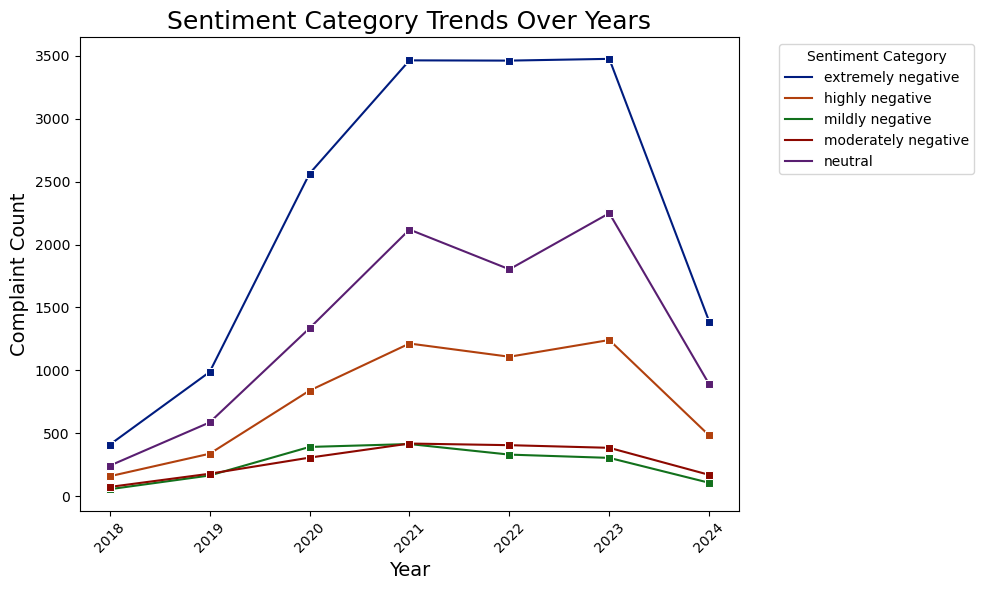

In [38]:
# Calculate the number of complaints per emotion category per year
yearly_sentiment_count = data.groupby(['year', 'sentiment_label']).size().reset_index(name='complaint_count')

plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_sentiment_count, x='year', y='complaint_count', hue='sentiment_label', marker='s', palette='dark')

# Set the chart title and label
# plt.title('Sentiment Category Trends Over Years', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Complaint Count', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Sentiment Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

From the line chart showing changes in customer sentiment over the years, it is evident that the number of complaints with extremely negative sentiment has been increasing annually from 2018 to 2023, indicating a rise in customer dissatisfaction. This underscores the need for insurance companies to enhance customer understanding of insurance terms and avoid over-exaggerating product promotions to prevent misunderstandings and complaints due to information asymmetry, ultimately improving customer satisfaction.

# Feature Engineering

- **Remove Irrelevant Variables**: Through Exploratory Data Analysis (EDA) and correlation analysis, we have determined that certain variables, such as 'quarter', 'month', 'day_of_week', have low correlation with the 'decision' variable. Additionally, to prevent data leakage, the 'What I’ve decided – and why' column should be removed. Variables used for plotting in EDA or those that are irrelevant, such as 'decision_id' and 'date', should also be excluded from the analysis. 

- **Separate Feature and Target Variables**

- **Use TF-IDF to convert Text into Numbers** (keyword counting)

Feature Processing:

- **One-hot Encoding for Categorical Variables**
- **Standardization for Numerical Variables**

In [35]:
data.columns # check what features we have now

Index(['decision_id', 'date', 'company', 'decision', 'The complaint',
       'What happened', 'What I’ve decided – and why', 'insurance_type',
       'complaint_reason', 'sentiment_score', 'sentiment_label', 'month',
       'day_of_week', 'year', 'dispute_duration', 'insurance_type_first_word',
       'complaint_reason_filtered', 'quarter'],
      dtype='object')

Through correlation analysis in the EDA, we removed some variables that have a correlation with the decision smaller than 0.1, as well as some unrelated variables that were previously used for plotting.

In [11]:
data.drop(['decision_id', 'date', 'What I’ve decided – and why','insurance_type_first_word', 'sentiment_label', 'dispute_duration','quarter', 'month', 'day_of_week','complaint_reason_filtered'], axis=1,inplace=True)

In [37]:
data.columns

Index(['company', 'decision', 'The complaint', 'What happened',
       'insurance_type', 'complaint_reason', 'sentiment_score', 'year'],
      dtype='object')

In [11]:
data.info() # print the information for each feature now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34048 entries, 0 to 34047
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           34048 non-null  object 
 1   decision          34048 non-null  object 
 2   The complaint     34035 non-null  object 
 3   What happened     32221 non-null  object 
 4   insurance_type    34048 non-null  object 
 5   complaint_reason  34048 non-null  object 
 6   sentiment_score   34048 non-null  float64
 7   year              34048 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.1+ MB


In [13]:
# Merge The 'The complaint' and 'What happened' columns
data['combined_text'] = data['The complaint'].fillna('') + ' ' + data['What happened'].fillna('')

# Separate feature and target variables
y = data['decision'].apply(lambda x: 1 if x == 'Upheld' else 0)
X = data.drop(['decision', 'The complaint', 'What happened'], axis=1)

In [15]:
# Combine 'The complaint' and 'What happened' columns
data['combined_text'] = data['The complaint'].fillna('') + ' ' + data['What happened'].fillna('')

# Extract important keywords using TF-IDF, removing common stop words
tfidf_vectorizer = TfidfVectorizer(max_features=3500, stop_words='english')  
tfidf_matrix = tfidf_vectorizer.fit_transform(data['combined_text'])

# Get important keywords
important_keywords = tfidf_vectorizer.get_feature_names_out()

# Filter out purely numeric words and words shorter than three letters
filtered_keywords = [kw for kw in important_keywords if not kw.isdigit() and len(kw) >= 3]

# Create a DataFrame to store keyword occurrence counts
keyword_counts = pd.DataFrame(np.zeros((data.shape[0], len(filtered_keywords))), columns=filtered_keywords)

# Calculate the occurrence count of each keyword in the text
for keyword in filtered_keywords:
    keyword_counts[keyword] = data['combined_text'].apply(lambda x: x.split().count(keyword))

# Numerical processing
scaler = StandardScaler()

# Encode categorical variables
categorical_features = ['company', 'insurance_type', 'complaint_reason', 'year']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Process numerical features
X_numeric = scaler.fit_transform(data[['sentiment_score']])

# Process categorical features
X_categorical = categorical_transformer.fit_transform(data[categorical_features])

# Get the names of the categorical features
categorical_feature_names = categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)

# Combine all features
X_final = hstack([keyword_counts.values, X_numeric, X_categorical])

# Combine all feature names
feature_names = filtered_keywords + ['sentiment_score'] + list(categorical_feature_names)

# Predictive Modelling

Through Exploratory Data Analysis (EDA), we have identified that the decisions made by the Financial Ombudsman Service (FOS) are crucial for Simply Business. There are some reasons:

1. **Impact on Customer Satisfaction**: Our analysis revealed that the sentiment of complaints, particularly those with extremely negative sentiments, has been rising over the years. This rise is correlated with the increasing number of complaints not upheld by FOS. This trend highlights the importance of FOS decisions on overall customer satisfaction and perception of Simply Business.

2. **Strategic Decision Making**: Insights from FOS decisions can guide strategic business decisions. For instance, products or services with higher rates of upheld complaints might need a redesign or additional support mechanisms.

3. **Resource Allocation**: By understanding which complaints are more likely to be upheld, Simply Business can allocate resources more efficiently. For example, more focus can be placed  home insurance complaint from EDA, which have shown significant increases and more upheld, ensuring that these complaints are handled more effectively to improve customer outcomes.

First, we need to understand the distribution of the target variable.

The target variable is roughly balanced, so we do not need to use oversampling to balance the data.

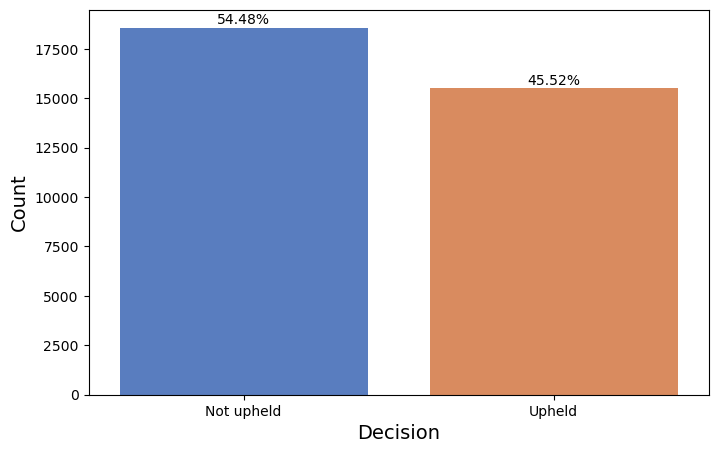

In [6]:
# Calculate percentages for each type of decision
decision_counts = data['decision'].value_counts()
decision_percentages = (decision_counts / len(data)) * 100

# Draw a bar chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=decision_counts.index, y=decision_counts.values, palette="muted")

# Percentages are displayed on each bar
for i, percentage in enumerate(decision_percentages):
    ax.text(i, decision_counts.values[i] + 50, f'{percentage:.2f}%', ha='center', va='bottom')

# plt.title('Distribution of Decision',fontsize =18)
plt.xlabel('Decision',fontsize =14)
plt.ylabel('Count',fontsize =14)
plt.show()

We want to use the train_test_split function to divide the feature data `X_final` and the target variable `y` into training and testing sets, with 30% of the data used for the test set and 70% for the training set. By setting random_state = 42, it ensures that the split results are the same each time the code is run, enhancing reproducibility. Additionally, using stratify = y ensures that the distribution of the target variable y in the training and testing sets matches the original dataset, which is particularly important for classification problems to prevent unequal distribution of classes in the training and testing sets.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42, stratify=y)

## Model Selection

In this subsection, we performed differen binary classification models. And, I used the GridSearchCV method to perform a grid search on the model's parameters to achieve a certain level of optimization.

For each of these models below, I trained and validated based on classification report and confusion_matrix. And I outputed the plot of the top 20 important features.

- Logistic Regression Model
- Random Forest Model
- XGBoost Model
- Ensemble Model

### Logistic Regression

In [7]:
# Define the parameter grid for Logistic Regression
log_reg_param_grid = {
    'C': [0.01, 0.1, 1],
    'solver': ['lbfgs', 'liblinear']
}

# Create the Logistic Regression model
log_reg = LogisticRegression(max_iter=6000, random_state=1)

# Use GridSearchCV for hyperparameter tuning
log_reg_cv = GridSearchCV(log_reg, log_reg_param_grid, cv=5, scoring='accuracy')
log_reg_cv.fit(X_train, y_train)

# Output the best parameters
print("Best parameters for Logistic Regression:", log_reg_cv.best_params_)

# Predict the test set
y_pred_log_reg = log_reg_cv.predict(X_test)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log_reg))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))

Best parameters for Logistic Regression: {'C': 0.01, 'solver': 'liblinear'}
Logistic Regression Accuracy: 0.68928046989721
Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.68      0.80      0.74      5566
           1       0.70      0.56      0.62      4649

    accuracy                           0.69     10215
   macro avg       0.69      0.68      0.68     10215
weighted avg       0.69      0.69      0.68     10215

Logistic Regression Confusion Matrix:
 [[4450 1116]
 [2058 2591]]


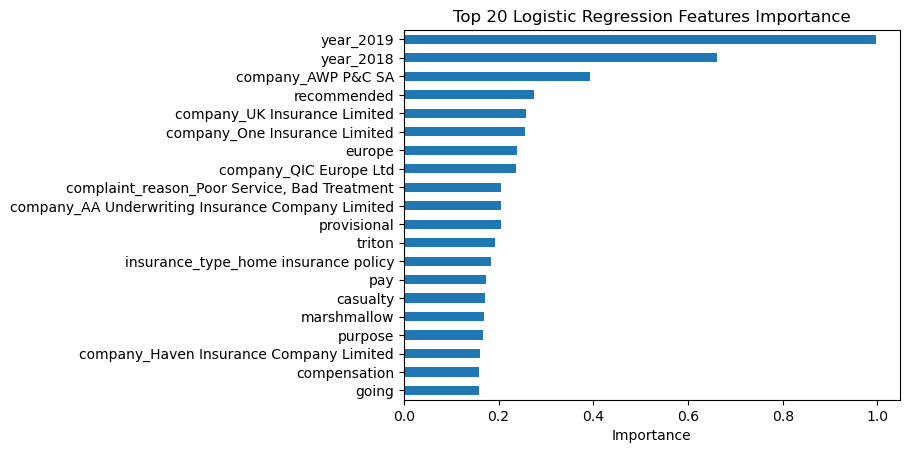

In [11]:
# Sets the number of most important features for visualization
n_top_features = 20

# Feature Importance - logistic regression
log_reg_coef = log_reg_cv.best_estimator_.coef_.flatten()
log_reg_importance = pd.Series(log_reg_coef, index=feature_names)
log_reg_importance.sort_values(ascending=False, inplace=True)
log_reg_importance.head(n_top_features).plot(kind='barh', title='Top 20 Logistic Regression Features Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()  
plt.show()

### Random Forest

In [6]:
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [500, 800],  # Number of trees in the forest
    'max_depth': [30, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 3],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True]  # Whether bootstrap samples are used when building trees
}

# Create the Random Forest model
rf_clf = RandomForestClassifier(random_state=1)

# Use GridSearchCV for hyperparameter tuning
rf_cv = GridSearchCV(rf_clf, rf_param_grid, cv=5, scoring='accuracy')
rf_cv.fit(X_train, y_train)

# Output the best parameters
print("Best parameters for Random Forest:", rf_cv.best_params_)

# Predict the test set
y_pred_rf = rf_cv.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
Random Forest Accuracy: 0.7061184532550171
Random Forest Report:
               precision    recall  f1-score   support

  Not upheld       0.69      0.83      0.75      5566
      Upheld       0.73      0.56      0.63      4649

    accuracy                           0.71     10215
   macro avg       0.71      0.69      0.69     10215
weighted avg       0.71      0.71      0.70     10215

Random Forest Confusion Matrix:
 [[4609  957]
 [2045 2604]]


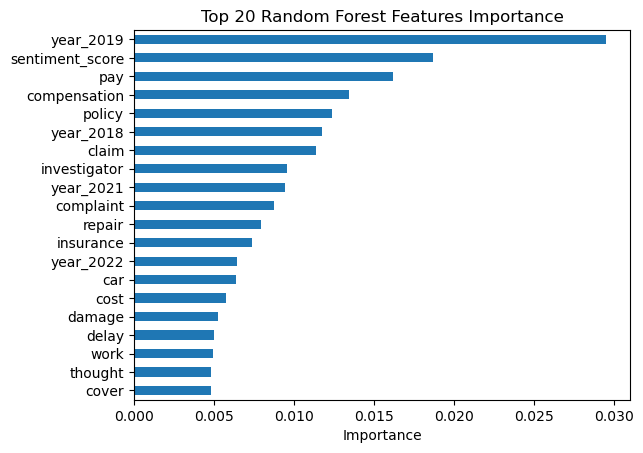

In [14]:
# Feature Importance - Random Forest
rf_importance = pd.Series(rf_cv.best_estimator_.feature_importances_, index=feature_names)
rf_importance.sort_values(ascending=False, inplace=True)
rf_importance.head(n_top_features).plot(kind='barh', title='Top 20 Random Forest Features Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()  
plt.show()

### XGBoost

In [16]:
# Define a grid for XGBoost
xgb_param_grid = {
    'n_estimators': [500, 800],
    'learning_rate': [0.01, 0.05],
    'max_depth': [7],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Set the XGBoost model
xgb_clf = XGBClassifier(random_state=1, eval_metric='logloss')

# Use GridSearchCV to tune parameters and fit model
xgb_cv = GridSearchCV(xgb_clf, xgb_param_grid, cv=5, scoring='accuracy')
xgb_cv.fit(X_train, y_train)

print("Best parameters for XGBoost:", xgb_cv.best_params_)

# Predict the decision result
y_pred_xgb = xgb_cv.predict(X_test)

# Evaluate XGBoost model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 800, 'subsample': 0.8}
XGBoost Accuracy: 0.7077826725403817
XGBoost Report:
               precision    recall  f1-score   support

           0       0.70      0.80      0.75      5566
           1       0.72      0.59      0.65      4649

    accuracy                           0.71     10215
   macro avg       0.71      0.70      0.70     10215
weighted avg       0.71      0.71      0.70     10215

XGBoost Confusion Matrix:
 [[4471 1095]
 [1890 2759]]


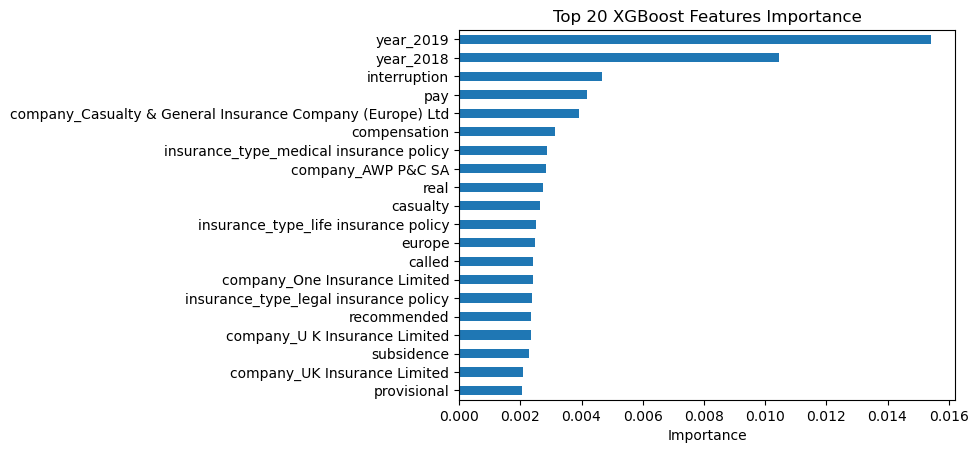

In [17]:
# Feature Importance - XGBoost
xgb_importance = pd.Series(xgb_cv.best_estimator_.feature_importances_, index=feature_names)
xgb_importance.sort_values(ascending=False, inplace=True)
xgb_importance.head(n_top_features).plot(kind='barh', title='Top 20 XGBoost Features Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis() 
plt.show()

### Ensemble model (voting classifier)

The reason for attempting to use an ensemble model with these three models (Logistic Regression, Random Forest, and XGBoost) lies in the several key advantages of ensemble learning methods. These advantages generally make ensemble models perform better in prediction tasks than individual models alone.

- **Reducing Bias and Variance**: By combining the predictions of these models, an ensemble model can balance the bias and variance of different models, leading to improved overall performance.

    1. Logistic Regression: This model typically has low variance but may have high bias, as it assumes the data is linearly separable. If the true distribution of the data is complex, Logistic Regression may not fit well.
    2. Random Forest: This model reduces variance by building multiple decision trees and voting, but it may still suffer from bias, especially if the depth of individual trees is limited.
    3. XGBoost: This model reduces bias by iteratively building trees but may overfit high-variance data.

- **Leveraging the Strengths of Different Models**:Combining these models allows the ensemble to leverage the strengths of each model, leading to better performance under various data conditions.

    1. Logistic Regression: Simple and interpretable, suitable for linearly related data.
    2. Random Forest: Excels at handling nonlinear relationships and high-dimensional data, with good robustness and stability.
    3. XGBoost: Performs exceptionally well with sparse data and missing values, and has shown outstanding performance in many Kaggle competitions.
    

- **Improving Stability and Robustness**:
An ensemble model, by combining the predictions of multiple independent models, is typically more stable and robust than individual models. Even if one model performs poorly on certain subsets of the data, the predictions from other models can compensate, improving overall accuracy and reliability.

- **Reducing the Risk of Overfitting**:
A single complex model, such as XGBoost, might overfit the training data, whereas combining multiple models with different levels of complexity can mitigate this risk. By using a soft voting mechanism, the weights of each model are appropriately balanced, ensuring that the ensemble model does not overfit the training data while performing well on the test data.

In [18]:
# Create an ensemble model using the tuned models
voting_clf = VotingClassifier(estimators=[
    ('log_reg', log_reg_cv.best_estimator_),  # Logistic Regression with best parameters
    ('rf', rf_cv.best_estimator_),  # Random Forest with best parameters
    ('xgb', xgb_cv.best_estimator_)  # XGBoost with best parameters
], voting='soft', weights=[1, 2, 3])  # Use 'soft' voting mechanism

# Train the ensemble model
voting_clf.fit(X_train, y_train)

# Predict the test set
y_pred_voting = voting_clf.predict(X_test)

# Evaluate the ensemble model
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Voting Classifier Report:\n", classification_report(y_test, y_pred_voting))
print("Voting Classifier Confusion Matrix:\n", confusion_matrix(y_test, y_pred_voting))

Voting Classifier Accuracy: 0.7111111111111111
Voting Classifier Report:
               precision    recall  f1-score   support

           0       0.70      0.82      0.76      5566
           1       0.73      0.58      0.65      4649

    accuracy                           0.71     10215
   macro avg       0.71      0.70      0.70     10215
weighted avg       0.71      0.71      0.71     10215

Voting Classifier Confusion Matrix:
 [[4554 1012]
 [1939 2710]]


Although the accuracy improvement of the ensemble model is not significant, it may still be more stable and robust than individual models, especially when dealing with different datasets. By combining the predictions of multiple models, ensemble models can reduce the instability that individual models might exhibit on certain data subsets. However, considering the need for good interpretability, we ultimately recommend using the Random Forest model as the final choice.